# PoP Intensity

For a deeper dive into the project and to explore all the details, please visit our [README file](readme.md). You'll find everything you need to know, from the project's background and objectives to the nitty-gritty of how it works.

- Date: 2025.01.05
- Researchers:
    - Dr. Lázaro Bustio-Martínez
    - Dr. Vitali Herrera-Semenets
    - Dr. Miguel Á. Álvarez-Carmona
    - Dr. Jorge Á. González-Ordiano
    - Dr. Jan van den Berg
    - Dr. Pedro Á. Santander-Molina
- Contact: [Dr. Lázaro Bustio Martínez](lazaro.bustio@ibero.mx).
- Python version: 3.12.8

Determine the intensity level for each principle of persuasion. This code is developed for Python 3.12.8.

# Setting the working environment

The philosophy followed in this Notebook is that everything needed for its execution will be installed, referenced, and configured within the Notebook itself. In this way, the Notebook can be executed smoothly on any other system

## Defining logging

In [1]:
import logging

# Colores ANSI
class LogColors:
    INFO_BOLD = "\033[1;32m"  # Verde intenso (negrita) para INFO
    INFO = "\033[0;32m"  # Verde suave para INFO (esto lo cambiaré a verde lima)
    WARNING_BOLD = "\033[1;33m"  # Amarillo intenso (negrita) para WARNING
    WARNING = "\033[0;33m"  # Amarillo suave para WARNING
    ERROR_BOLD = "\033[1;31m"  # Rojo intenso (negrita) para ERROR
    ERROR = "\033[0;31m"  # Rojo suave para ERROR
    RESET = "\033[0m"  # Resetear el color

# Formateador personalizado
class ColoredFormatter(logging.Formatter):
    def format(self, record):
        # Colorear el tipo de mensaje (levelname) y el mensaje del log
        if record.levelname == "INFO":
            record.levelname = f"{LogColors.INFO_BOLD}{record.levelname}{LogColors.RESET}"
            record.msg = f"{LogColors.INFO}{record.msg}{LogColors.RESET}"
        elif record.levelname == "WARNING":
            record.levelname = f"{LogColors.WARNING_BOLD}{record.levelname}{LogColors.RESET}"
            record.msg = f"{LogColors.WARNING}{record.msg}{LogColors.RESET}"
        elif record.levelname == "ERROR":
            record.levelname = f"{LogColors.ERROR_BOLD}{record.levelname}{LogColors.RESET}"
            record.msg = f"{LogColors.ERROR}{record.msg}{LogColors.RESET}"
       
        return super().format(record)

# Configuración del logger
logger = logging.getLogger("MiLogger")
logger.setLevel(logging.INFO)

# Evitar manejadores duplicados
logger.handlers.clear()

# Manejador de consola con colores
console_handler = logging.StreamHandler()
formato = ColoredFormatter("%(asctime)s: %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
console_handler.setFormatter(formato)
logger.addHandler(console_handler)

# Desactivar el logger raíz (limpiar los manejadores raíz)
logging.getLogger().handlers.clear()

# Ejemplo de uso
logger.info("The code has started running correctly.")
logger.warning("This is a warning message.")
logger.error("An error occurred in the code.")

2025-01-09 21:31:19: INFO - The code has started running correctly.
2025-01-09 21:31:19: WARNING - This is a warning message.
2025-01-09 21:31:19: ERROR - An error occurred in the code.


## Installing Libraries

To avoid compatibility issues among different environments, all the necessary libraries are first installed and then imported. Any additional libraries needed should be installed in this cell before importing.

In [2]:
logger.info("Starting the installation of required libraries...")

#%pip install pandas
#%pip install numpy
#%pip install matplotlib
#%pip install seaborn
#%pip install scipy
#%pip install scikit-learn
#%pip install transformers
#%pip install pandasgui
#%pip install torch
#%pip install psutil 
#%pip install gputil
#%pip install hdbscan
#%pip install prettytable
#%pip install gputils
#%pip install plotly

2025-01-09 21:31:19: INFO - Starting the installation of required libraries...


## Imports

After installing the libraries, then they can be imported and used in the code.

In [3]:
import os
import pickle
import platform
import warnings

import numpy as np
import pandas as pd
import psutil
import torch
import gputils

import hdbscan
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import prettytable
from prettytable import PrettyTable

from itertools import product
import re

# Scikit-learn imports
import sklearn
from sklearn.cluster import (AffinityPropagation, DBSCAN, KMeans, MeanShift,
                             OPTICS, SpectralClustering)
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Transformers imports
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import __version__ as transformers_version

import pandasgui
from pandasgui import show

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

logger.info("Starting the import of necessary libraries for the project...")


2025-01-09 21:31:29: INFO - Starting the import of necessary libraries for the project...


## Defining constant variables

In [4]:
# Principles of Persuasion
# Definition of the persuasion principles that will be used in the analysis
POPS = [
    "authority",                            # Authority principle: people tend to follow those they consider experts
    "distraction",                          # Distraction: diverting the audience's attention to influence their decision
    "liking_similarity_deception",          # Liking and similarity: people are more likely to be persuaded by those they like or who are similar to them, even if deception is involved
    "social_proof",                         # Social proof: the influence that others' behavior has on decision-making
    "commitment_integrity_reciprocation"    # Commitment, integrity, and reciprocity: the desire to be consistent with prior commitments and the tendency to return favors
]

# Tokenization model used for processing text
TOKENIZER = "distilbert-base-uncased"  # DistilBERT-based tokenizer that converts text into tokens for the model

# Embeddings model used to represent words or phrases in a vector space
EMBEDDINGS_MODEL = "distilbert-base-uncased"  # DistilBERT model that generates embeddings for words, useful for NLP tasks

# Numero maximo para la busqueda del numero optimo de clusters
MAX_K = 11 # Se establece en 11, para que el rango de busqueda sea de 2 a 10.

# Resultados para el principio de persuasion que se está analizando
PRINCIPLE_FOLDER = ""

# Objetivos de los graficos que se generarán
PLOT_OBJECTIVES = ("optimum_k", "normal_plot")

# Folders de trabajo
RESULT_FOLDER = "results"   # Carpeta donde se guardarán los resultados
DATA_FOLDER = "data"        # Carpeta donde se guardarán los datos
MODEL_FOLDER = "models"     # Carpeta donde se guardarán los modelos     
TEMP_FOLDER = "temp"        # Carpeta donde se guardarán los datos temporales


## Configuring working folders

All working folders will be established and configured here.

In [5]:
logger.info("Creating folders for the project...")
try:    
    logger.info(f"Creating folder {RESULT_FOLDER}...")
    if not os.path.exists(RESULT_FOLDER):
        os.makedirs(RESULT_FOLDER)
        logger.info(f"Folder {RESULT_FOLDER} created successfully.")
    else:
        logger.info(f"Folder {RESULT_FOLDER} already exists.")
    
    logger.info(f"Creating folder {DATA_FOLDER}...")
    if not os.path.exists(DATA_FOLDER):
        os.makedirs(DATA_FOLDER)
        logger.info(f"Folder {DATA_FOLDER} created successfully.")
    else:
        logger.info(f"Folder {DATA_FOLDER} already exists.")
    
    logger.info(f"Creating folder {MODEL_FOLDER}...")
    if not os.path.exists(MODEL_FOLDER):
        os.makedirs(MODEL_FOLDER)
        logger.info(f"Folder {MODEL_FOLDER} created successfully.")
    else:
        logger.info(f"Folder {MODEL_FOLDER} already exists.")
    
    logger.info(f"Creating folder {TEMP_FOLDER}...")
    if not os.path.exists(TEMP_FOLDER):
        os.makedirs(TEMP_FOLDER)
        logger.info(f"Folder {TEMP_FOLDER} created successfully.")
    else:
        logger.info(f"Folder {TEMP_FOLDER} already exists.")
        
    logger.info("Folders created successfully.")
except Exception as e:
    logger.error(f"Error creating folders: {e}")

2025-01-09 21:31:29: INFO - Creating folders for the project...
2025-01-09 21:31:29: INFO - Creating folder results...
2025-01-09 21:31:29: INFO - Folder results already exists.
2025-01-09 21:31:29: INFO - Creating folder data...
2025-01-09 21:31:29: INFO - Folder data already exists.
2025-01-09 21:31:29: INFO - Creating folder models...
2025-01-09 21:31:29: INFO - Folder models already exists.
2025-01-09 21:31:29: INFO - Creating folder temp...
2025-01-09 21:31:29: INFO - Folder temp already exists.
2025-01-09 21:31:29: INFO - Folders created successfully.


## Saving configurations of the VENV

Once again, to avoid compatibility issues, generate the requirements file from the libraries used ans save it in `requirements.txt` file.

In [6]:
# Generar requirements.txt 
%pip freeze > requirements.txt
logger.info("'requirements.txt' file has been generated successfully!")

2025-01-09 21:31:30: INFO - 'requirements.txt' file has been generated successfully!


Note: you may need to restart the kernel to use updated packages.


## Checking hardware resources

Retrieve the versions of the utilized libraries to ensure compatibility and consistency across different environments.

In [7]:
def get_library_versions():
    """Returns a DataFrame with the versions of key libraries used in the project."""
    library_versions = {
        "Library": ["pandas", "numpy", "matplotlib", "seaborn", "scipy", "scikit-learn", "transformers", "prettytable", "torch", "pandasgui"],
        "Version": [
            pd.__version__,
            np.__version__,
            matplotlib.__version__,
            sns.__version__,
            sklearn.__version__,
            transformers_version,  # Ensure this variable is defined in your code
            prettytable.__version__,
            torch.__version__,
            show.__module__.split('.')[0]  # Not version-specific
        ]
    }
    return pd.DataFrame(library_versions)

def get_system_info():
    """Returns a DataFrame with system information, including CPU, RAM, GPU, and NPU details."""
    system_info = {
        "Info": ["Python version", "Platform", "Processor", "Architecture", "Number of CPUs", "Total RAM"],
        "Details": [
            platform.python_version(),
            f"{platform.system()} {platform.release()}",
            platform.processor(),
            platform.architecture()[0],
            psutil.cpu_count(logical=True),
            f"{psutil.virtual_memory().total / (1024 ** 3):.2f} GB"
        ]
    }

    # GPU details using GPUtil
    gpus = gputils.getGPUs()
    if gpus:
        for gpu in gpus:
            system_info["Info"].append(f"GPU: {gpu.name}")
            system_info["Details"].append(f"Memory Total: {gpu.memoryTotal} MB")
            system_info["Info"].append("GPU Memory Free")
            system_info["Details"].append(f"{gpu.memoryFree} MB")
            system_info["Info"].append("GPU Memory Used")
            system_info["Details"].append(f"{gpu.memoryUsed} MB")
            system_info["Info"].append("GPU Utilization")
            system_info["Details"].append(f"{gpu.memoryUtil * 100:.2f}%")
    else:
        system_info["Info"].append("GPU")
        system_info["Details"].append("No GPU detected with GPUtil.")

    # GPU details using PyTorch (alternative)
    if torch.cuda.is_available():
        gpu_count = torch.cuda.device_count()
        for i in range(gpu_count):
            system_info["Info"].append(f"CUDA GPU {i}: {torch.cuda.get_device_name(i)}")
            system_info["Details"].append(f"GPU Capability: {torch.cuda.get_device_capability(i)}")
            system_info["Info"].append("Total Memory")
            system_info["Details"].append(f"{torch.cuda.get_device_properties(i).total_memory / (1024 ** 3):.2f} GB")
    else:
        system_info["Info"].append("GPU")
        system_info["Details"].append("No GPU detected with PyTorch.")

    return pd.DataFrame(system_info)


## Get library versions and system info
#library_df = get_library_versions()
#system_df = get_system_info()

## Display library versions using PrettyTable
#library_table = PrettyTable()
#library_table.field_names = ["Library", "Version"]
#for index, row in library_df.iterrows():
#    library_table.add_row([row['Library'], row['Version']])
#print("Loaded libraries and their versions:")
#print(library_table)

# Display system info using PrettyTable
#system_table = PrettyTable()
#system_table.field_names = ["Info", "Details"]
#for index, row in system_df.iterrows():
#    system_table.add_row([row['Info'], row['Details']])
#print("\nSystem information:")
#print(system_table)


# Data gathering and filtering

Phishing messages and principles of persuasion are stored in `data\pop_dataset_Full(Tiltan).csv` that needs to be loaded.

In [8]:
# Los datos se encuentran en el archivo 'pop_dataset_Full(Tiltan).csv'
file_name = "pop_dataset_Full(Tiltan).csv"

# Validación de la existencia de la carpeta de datos
if os.path.exists(DATA_FOLDER):
    path = os.path.join(DATA_FOLDER, file_name)
    
    # Validación de la existencia del archivo CSV
    if os.path.exists(path):
        logger.info(f"Starting data processing by reading the file located at '{path}'...")

        try:
            data_df = pd.read_csv(path, header=1)
            logger.info("Data loaded successfully.")
        except Exception as e:
            logger.error(f"Error reading the CSV file: {e}")
            raise

        # Validación de las columnas esperadas
        expected_columns = ["id", "path", "hash", "subject", "txt"] + POPS + ["class", "label"]
        missing_columns = [col for col in expected_columns if col not in data_df.columns]
        
        if missing_columns:
            logger.error(f"The following expected columns are missing from the data: {missing_columns}")
            raise ValueError(f"Missing columns: {missing_columns}")

        # Solo son necesarios los textos de phishing ("class==1"), los legítimos no son interesantes en este punto.
        data_phish = data_df[data_df["class"] == 1]
        
        # Validación de que hay datos de phishing disponibles
        if data_phish.empty:
            logger.warning("No phishing data found in the dataset.")
        
        # Seleccionar las columnas necesarias
        data = data_phish[expected_columns]
        print(data.head())
    else:
        logger.error(f"The file '{file_name}' does not exist in the folder '{DATA_FOLDER}'. Please check the file name and location.")
else:
    logger.error(f"The data folder '{DATA_FOLDER}' does not exist. Please create it and place the data file in it.")

2025-01-09 21:31:30: INFO - Starting data processing by reading the file located at 'data\pop_dataset_Full(Tiltan).csv'...
2025-01-09 21:31:30: INFO - Data loaded successfully.


        id                                               path  \
1087  9762  /content/gdrive/MyDrive/Colabs/02.-Proyectos/P...   
1088  9763  /content/gdrive/MyDrive/Colabs/02.-Proyectos/P...   
1089  9764  /content/gdrive/MyDrive/Colabs/02.-Proyectos/P...   
1090  9765  /content/gdrive/MyDrive/Colabs/02.-Proyectos/P...   
1091  9766  /content/gdrive/MyDrive/Colabs/02.-Proyectos/P...   

                                  hash  \
1087  52f8f694517011d944083f22ace9448e   
1088  b4dab37a7c9be664f7bbd4a5f48e9409   
1089  c5a00795f1af36457fa3e6da1ce902ce   
1090  5d668953b7cf30441baffbb296702768   
1091  0009311d8938d26b6807618aa3febc78   

                                      subject  \
1087    Urgent Fraud Prevention Group Notice    
1088          your paypal account user domain   
1089    Notification Update Your eBay Profile   
1090  Thanks again for using online payments    
1091                   PayPal Flagged Account   

                                                    txt  auth

# Data representation

Messages are stored as text, but they need to be represented in a way that facilitates processing. The data representation method that works best for phishing detection is BERT. BERT (Bidirectional Encoder Representations from Transformers) has the ability to understand the context of words in both directions, enabling better interpretation and analysis of the text. Additionally, BERT has proven highly effective in text classification tasks and detecting anomalous patterns—essential characteristics for identifying phishing messages. Leveraging these capabilities, BERT can more accurately detect malicious messages and protect users against phishing attacks.

To implement this, DistilBERT is employed. DistilBERT uses a tokenizer that converts the input text into tokens that the model can process. This model is a smaller, faster, and lighter version of BERT, designed to deliver high performance while requiring fewer computational resources. An informational log entry is added to indicate that both the DistilBERT tokenizer and model have been loaded successfully. By utilizing DistilBERT, which retains 97% of BERT's language understanding capabilities while being more efficient, the system enhances its ability to detect phishing attempts in a streamlined and resource-effective manner.

**NOTE:** other data repesentations can, and in matter of fact, must be tested. Following DistlBERT, GloVe will be also tested.

In [9]:
# Cargar el tokenizer y el modelo base de DistilBERT
try:
    tokenizer = DistilBertTokenizer.from_pretrained(TOKENIZER)
    model = DistilBertModel.from_pretrained(EMBEDDINGS_MODEL)  # Modelo base
    logger.info(f"Tokenizer '{TOKENIZER}' and model '{EMBEDDINGS_MODEL}' have been downloaded/loaded successfully!")
except Exception as e:
    logger.error(f"Error downloading/loading '{TOKENIZER}' tokenizer and model: {e}")

2025-01-09 21:31:31: INFO - Tokenizer 'distilbert-base-uncased' and model 'distilbert-base-uncased' have been downloaded/loaded successfully!


It is needed to define a function that processes a list of texts to generate their embeddings using a pre-trained model.

In [10]:
# Función para obtener embeddings del texto
def get_embeddings(texts):
    logger.info("Starting to process texts for embeddings...")
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    logger.info(f"Tokenized {len(texts)} texts.")
    
    with torch.no_grad():
        logger.info("Generating embeddings...")
        outputs = model(**inputs)
    
    # Usamos la media de los embeddings de las palabras (output.last_hidden_state)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    
    logger.info(f"Generated embeddings with shape: {embeddings.shape}")
    return embeddings

Following it is needed to filter messages according to different principles of persuasion and to calculate their vector representations, known as **embeddings**. To do so, the corresponding embedding representation is calculated for each principle of persuasion.

It is very complicated, in terms of the necessary data structures, to automatically analyze all the principles of persuasion in a single piece of code. Therefore, to address this situation, one principle of persuasion will be analyzed at a time. The variable `pop` will contain the principle of persuasion to be analyzed, and it will be checked that pop is in the list of persuasion principles in the data to avoid errors later on.

In [11]:
# En este momento, el principio de interés que se utilizará en el análisis es "authority". Este valor se puede cambiar para evaluar otros principios.
pop = "authority"
PRINCIPLE_FOLDER = pop

if (pop not in POPS):
    logger.error(f"Error: '{pop}' is not a valid principle of persuasion.")
else:
    logger.info(f"'{pop}' has been established as the principle of persuasion of interest at this time. Continuing with the analysis...")

2025-01-09 21:31:31: INFO - 'authority' has been established as the principle of persuasion of interest at this time. Continuing with the analysis...


Here, the phishing messages are filtered to include only those that correspond to the principle of persuasion specified in the `pop` variable. Subsequently, the selected messages are transformed using the chosen data representation method. 

In [12]:
logger.info(f"Creating embeddings with '{EMBEDDINGS_MODEL}' representation for '{pop}'...")

# Filtrar las filas donde el principio en cuestión tenga valor 1
filtered_df = data.loc[data[pop] == 1, ['id', 'path', 'hash', 'subject', 'txt']]

# Obtener embeddings para los textos
embed = get_embeddings(filtered_df["txt"].tolist())

# Convertir las embeddings en DataFrame y agregar las columnas "label" y "class". Estas columnas se usarán
# para identificar los textos en el análisis de clustering y conectarlos con los embeddings correspondientes.
embed_df = pd.DataFrame(embed)
embed_df["id"] = filtered_df["id"].values
embed_df["path"] = filtered_df["path"].values

2025-01-09 21:31:31: INFO - Creating embeddings with 'distilbert-base-uncased' representation for 'authority'...
2025-01-09 21:31:31: INFO - Starting to process texts for embeddings...
2025-01-09 21:31:33: INFO - Tokenized 598 texts.
2025-01-09 21:31:33: INFO - Generating embeddings...
2025-01-09 21:32:49: INFO - Generated embeddings with shape: (598, 768)


Once the data has been processed for the current principle of persuasion, and its corresponding embeddings have been generated, the result is saved as a CSV file. This ensures that the data is stored in a compatible and easily accessible format for future use.

In [13]:
try:
    # Crear la ruta completa para la carpeta
    path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)
    
    # Verificar si la carpeta existe, si no, crearla
    if not os.path.exists(path):
        os.makedirs(path)  # Esto creará todas las carpetas necesarias

    # Crear el nombre del archivo
    file_name = f"embeddings_{pop}.csv"
    file_path = os.path.join(path, file_name)
    
    # Guardar el diccionario embeddings en un archivo JSON
    embed_df.to_csv(file_path, index=False, sep=",", decimal=".")
    logger.info(f"Embeddings for '{pop}' have been saved to '{file_path}' successfully!")

except Exception as e:
    logger.error(f"Error saving embeddings for '{pop}' to '{file_path}': {e}")

2025-01-09 21:32:49: INFO - Embeddings for 'authority' have been saved to 'results\authority\embeddings_authority.csv' successfully!


## Utils functions

This code uses recurrent support functions, which are included in this section.

In [14]:
def plot_line_chart(x_values, y_values, title, x_label, y_label, file_path, plot_objective=None, highlight_value=None, note=None):
    
    # Validations
    if not isinstance(x_values, (list, tuple)) or not isinstance(y_values, (list, tuple)):
        raise ValueError("x_values and y_values must be lists or tuples.")
    
    if len(x_values) != len(y_values):
        raise ValueError("x_values and y_values must have the same length.")
    
    if not isinstance(title, str) or not isinstance(x_label, str) or not isinstance(y_label, str):
        raise ValueError("Title, x_label, and y_label must be strings.")
    
    if plot_objective == "optimum_k" and highlight_value is None:
        raise ValueError("highlight_value must be provided when plot_objective is 'optimum_k'.")
    
    # Crear la figura del gráfico
    plt.figure(figsize=(8, 5))
    
    # Dibujar la línea
    plt.plot(x_values, y_values, 'bo-', label='Data')

    # Si se especifica el objetivo óptimo 'optimum_k', añadir una línea vertical en el valor resaltado
    if plot_objective == "optimum_k" and highlight_value is not None:
        plt.axvline(x=highlight_value, color='red', linestyle='--', label=f"Optimal k = {highlight_value}")
    
    # Agregar el título y las etiquetas de los ejes
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Mostrar la nota en el gráfico, si se pasa
    if note:
        plt.text(0.5, 0.95, note, horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes, fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.5))

    # Agregar la leyenda
    plt.legend()

    # Guardar el gráfico en el archivo especificado
    if file_path is not None:
        plt.savefig(file_path, format='png')
        logger.info(f"Chart saved at: '{file_path}'")
    
    # Mostrar el gráfico
    plt.show()
    plt.close()


Define a function to represent data using 2D Scatterplot

In [15]:
def plot_point_chart(x_values, y_values, clusters, title, x_label, y_label, file_path=None, plot_objective=None, highlight_value=None, note=None):
    
    # Validations
    if not isinstance(x_values, (list, tuple)) or not isinstance(y_values, (list, tuple)):
        raise ValueError("x_values and y_values must be lists or tuples.")
    
    if len(x_values) != len(y_values):
        raise ValueError("x_values and y_values must have the same length.")
    
    if not isinstance(title, str) or not isinstance(x_label, str) or not isinstance(y_label, str):
        raise ValueError("Title, x_label, and y_label must be strings.")
    
    if plot_objective == "optimum_k" and highlight_value is None:
        raise ValueError("highlight_value must be provided when plot_objective is 'optimum_k'.")
    
    # Crear un DataFrame para asociar clusters con puntos
    import pandas as pd
    plot_df = pd.DataFrame({
        'x': x_values,
        'y': y_values,
        'Cluster': clusters
    })

    # Crear el gráfico de dispersión
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=plot_df, x='x', y='y', hue='Cluster', palette='Set1', marker='o', s=100)

    # Título y etiquetas
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(title="Clusters", loc='best')

    # Si es necesario, agregar una línea vertical para destacar el valor 'highlight_value'
    if plot_objective == "optimum_k" and highlight_value is not None:
        plt.axvline(x=highlight_value, color='red', linestyle='--', label=f"Optimal k = {highlight_value}")
    
    # Si se proporciona la nota, agregarla al gráfico
    if note:
        plt.figtext(0.99, 0.01, note, horizontalalignment='right', fontsize=12, color='black', ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=1'))

    # Guardar el gráfico si se proporciona una ruta
    if file_path:
        plt.savefig(file_path, format='png')
        logger.info(f"Chart saved at: '{file_path}'")
    
    # Mostrar el gráfico
    plt.show()
    plt.close()


# Clustering

The premise guiding this research is that messages of equal intensity concerning a specific principle of persuasion should be grouped together. Therefore, it is essential to evaluate various clustering algorithms to identify which one generates the most consistent groups. Additionally, the research aims to verify whether the resulting groups indeed contain messages with similar intensities for each principle of persuasion. This approach not only seeks to enhance the understanding of message intensity but also to ensure that the selected algorithms effectively reflect the underlying similarities among the messages.

To achieve this, a pipeline will be implemented in which various clustering algorithms will be evaluated, including k-Means, DBSCAN, OPTICS, and Gaussian Mixture Models (while remaining open to the use of others). The algorithms that require specifying the number of groups to be constructed (such as k-Means and GMM) will analytically determine the optimal number of groups to obtain. The quality of each group will be assessed, and the messages within each group will be analyzed to verify the hypothesis that messages with similar intensities according to a given principle of persuasion will be clustered together.

## Defining and setting the configurations for the clustering algorithm selected

Two arrays will be defined to store the clustering algorithms (`clustering_algorithms`) and their respective configurations that will be used.

The `clustering_algorithms` dictionary is a structured configuration for testing and tuning various clustering algorithms. Each key in the dictionary corresponds to a clustering algorithm's name, and its value is another dictionary containing the following attributes:

- **`optimum_k`**: A boolean indicating whether the algorithm supports finding the optimal number of clusters (e.g., `True` for algorithms like KMeans and GaussianMixture that can compute metrics like Silhouette Score for different numbers of clusters).
- **`class`**: The actual class of the clustering algorithm (e.g., `KMeans`, `GaussianMixture`, or `DBSCAN`).
- **`params`**: A dictionary defining the hyperparameters to be tested for the specific algorithm. For example:
  - `n_clusters` or `n_components` are ranges of values for determining the number of clusters in KMeans or GaussianMixture, respectively.
  - Algorithms like `DBSCAN` and `OPTICS` specify parameters like `eps` (radius) and `min_samples` (minimum points in a cluster).
  - Algorithms that do not rely on a predefined number of clusters, like `HDBSCAN` or `MeanShift`, have `params` suited to their clustering strategies.

This structure allows flexible experimentation with different clustering algorithms and their hyperparameters, while enabling automated selection of the optimal number of clusters for applicable methods.

### Clustering Algorithms for Detecting Persuasion Principles in Phishing Messages

| **Algorithm**          | **Strengths**                                                                 | **Convenience for Detecting Persuasion Principles in Phishing Messages**                                                                                                                                                         |
|------------------------|-------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **KMeans**             | Efficient, easy to implement, and works well with spherical clusters.         | Useful when persuasion principles are distinct and well-separated, making it ideal for straightforward clustering tasks in phishing messages.                                                                                     |
| **GaussianMixture**    | Flexible, handles clusters of different shapes and densities.                | Effective for modeling complex, overlapping persuasion principles. Captures subtle or mixed principles within a single message.                                                                                                    |
| **SpectralClustering** | Handles non-convex clusters, uses graph-based methods for clustering.        | Suitable for detecting hidden relationships between messages that may have irregularly shaped or interconnected persuasion principles.                                                                                             |
| **DBSCAN**             | Density-based, groups points in high-density regions, marks outliers.        | Great for detecting dense areas of persuasion in phishing messages. Does not require the number of clusters to be predefined, making it adaptable to unexpected patterns.                                                             |
| **OPTICS**             | Handles varying densities, produces a reachability plot.                      | Useful for detecting density-based clusters with varying strengths in phishing messages. Captures persuasion principles that may vary in intensity across different messages.                                                           |
| **HDBSCAN**            | Hierarchical, density-based, robust to noise, determines the number of clusters automatically. | Effective for identifying clusters of persuasion principles where intensity varies. Great for noisy or irregular clustering patterns in phishing messages.                                                                          |
| **MeanShift**          | Non-parametric, finds dense areas without predefined clusters.               | Helps identify regions of high density when the number of persuasion principle clusters is unknown. Can discover unexpected patterns in phishing messages.                                                                            |
| **AffinityPropagation**| Message-passing, identifies exemplars, automatically determines the number of clusters. | Useful for detecting key persuasive messages that represent specific principles. No need for predefined cluster counts, which is ideal for discovering varied persuasion strategies in phishing messages.                         |

Each algorithm brings unique strengths to the task of detecting and analyzing the intensity of persuasion principles in phishing messages. By experimenting with different clustering algorithms, one can uncover various patterns and intensities of persuasion used in phishing attempts.

First, the maximum range for the optimal number of clusters, defined by `MAX_K`, is verified.

In [16]:
print(f"Maximum 'K' value for the search: {MAX_K}")

Maximum 'K' value for the search: 11


In [17]:
clustering_algorithms = {
    'KMeans': {
        'optimum_k': True,
        'class': KMeans,
        'params': {'n_clusters': range(2, MAX_K)}  # Valores para buscar el número óptimo de clusters
    },
    'GaussianMixture': {
        'optimum_k': True,
        'class': GaussianMixture,
        'params': {'n_components': range(2, MAX_K)}
    },
    'SpectralClustering': {
        'optimum_k': True,
        'class': SpectralClustering,
        'params': {'n_clusters': range(2, MAX_K), 'affinity': ['nearest_neighbors']}
    },
    'DBSCAN': {
        'optimum_k': False,
        'class': DBSCAN,
        'params': {'eps': [0.1, 0.2, 0.3, 0.5, 1.0], 'min_samples': [5, 10, 15]}  # Agregado min_samples
    },
    'OPTICS': {
        'optimum_k': False,
        'class': OPTICS,
        'params': {'min_samples': [5, 10, 15, 20], 'max_eps': [1.0, 1.5, 2.0]}  # Agregado max_eps
    },
    'HDBSCAN': {
        'optimum_k': False,
        'class': hdbscan.HDBSCAN,
        'params': {'min_cluster_size': [5, 10, 15, 20]}
    },
    'MeanShift': {
        'optimum_k': False,
        'class': MeanShift,
        'params': {}  # No requiere parámetros específicos
    },
    'AffinityPropagation': {
        'optimum_k': False,
        'class': AffinityPropagation,
        'params': {'damping': [0.5, 0.7, 0.9]}
    }
}

## Analytically detect the optimum number of clusters

Since the number of groups that emerge from the data is not known a priori (though it can be empirically estimated), it is important to automatically determine the optimal number of clusters for certain algorithms, such as k-Means, Gaussian Mixture Models (GMM), and Spectral Clustering. For other algorithms, such as DBSCAN, the number of clusters does not need to be specified in advance, as they can automatically detect clusters based on data density and other spatial relationships. However, the effectiveness of these density-based algorithms often depends on the correct selection of other parameters, such as the distance threshold (epsilon for DBSCAN) or the minimum number of points required to form a cluster (min_samples for DBSCAN and OPTICS). In practice, the number of clusters identified may vary depending on these parameters.

To determine the optimal number of clusters (`k`) for k-Means, GMM, and Spectral Clustering, the following function computes the best `k` based on the parameters defined in the `clustering_algorithms` dictionary. This function is applied to each of the clustering algorithms in `clustering_algorithms`.

The optimal number of clusters is determined using the [**Silhouette Score**](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html), which evaluates the quality of clustering by measuring how similar an object is to its own cluster compared to other clusters. The process involves the following steps:

1. **Iterating Over Cluster Counts**: For algorithms that allow specifying the number of clusters (e.g., KMeans, GaussianMixture, SpectralClustering), we iterate over a range of cluster numbers (e.g., from 2 to a predefined maximum `MAX_K`).

2. **Clustering for Each Value of K**: For each value of `k` (number of clusters), the algorithm is executed to generate cluster labels for the data.

3. **Calculating the Silhouette Score**: 
   - For each clustering result, the Silhouette Score is calculated using the formula:

    $$ S = \frac{b - a}{\max(a, b)} $$

     where:
     - `a` is the mean intra-cluster distance (distance to points within the same cluster).
     - `b` is the mean nearest-cluster distance (distance to points in the nearest different cluster).

   - The Silhouette Score ranges from -1 to 1:
     - A score close to **1** indicates well-separated clusters.
     - A score close to **0** suggests overlapping clusters.
     - A negative score indicates poor clustering.

4. **Selecting the Optimal K**: The value of `k` that yields the highest average Silhouette Score across all data points is selected as the optimal number of clusters.

5. **Visualization**: Optionally, a plot of Silhouette Scores versus the number of clusters is generated to visually confirm the optimal `k`.

This method ensures a data-driven approach to finding the optimal number of clusters, optimizing the quality of clustering while avoiding overfitting or underfitting.


In [18]:
def find_optimal_k(X, algorithm_info, export_path):

    algo_class = algorithm_info['class']
    algo_params = algorithm_info['params']

    # Inicialización para almacenar el número óptimo y los parámetros
    best_params = None
    optimal_k = None
    best_score = -1
    scores = []  # Lista para almacenar las puntuaciones

    for param_combination in product(*algo_params.values()):
        params = dict(zip(algo_params.keys(), param_combination))
        
        # Log con los parámetros que se están probando
        logger.info(f"Testing algorithm '{algo_class}' with parameters: {params}")
        
        try:
            # Crear el algoritmo de clustering con los parámetros actuales
            cluster_algo = algo_class(**params).fit(X)
            
            # Obtener las etiquetas dependiendo del algoritmo
            if issubclass(algo_class, KMeans) or issubclass(algo_class, GaussianMixture):
                # Para KMeans y GaussianMixture se usa el método `predict` o `labels_`
                labels = cluster_algo.predict(X) if isinstance(cluster_algo, GaussianMixture) else cluster_algo.labels_
            elif issubclass(algo_class, SpectralClustering):
                labels = cluster_algo.labels_
            elif issubclass(algo_class, DBSCAN) or issubclass(algo_class, OPTICS):
                # Para DBSCAN y OPTICS, usamos las etiquetas o `labels_`
                labels = cluster_algo.labels_
            elif issubclass(algo_class, hdbscan.HDBSCAN):
                # Para HDBSCAN, acceder correctamente a las etiquetas
                if hasattr(cluster_algo, 'labels_'):
                    labels = cluster_algo.labels_
                else:
                    logger.error(f"Error: 'labels_' not found in HDBSCAN model. This might indicate an issue with the fitting process.")
                    continue

            # Evaluar la calidad del clustering usando silhouette score
            if len(np.unique(labels)) > 1:
                score = silhouette_score(X, labels)
            else:
                score = -1  # Si no hay más de un grupo, asignamos un puntaje bajo

            # Agregar el puntaje a la lista
            scores.append(score)

            # Verificar si esta combinación de parámetros genera un mejor puntaje
            if score > best_score:
                best_score = score
                best_params = params
                optimal_k = len(np.unique(labels))

        except Exception as e:
            logger.error(f"Error with parameters {params} in algorithm '{algo_class}': {e}")
            continue  # Si algo falla con esta combinación, continuar con la siguiente

    if (optimal_k is None):
        logger.error(f"Could not determine the optimal number of clusters for '{algo_class}' with provided parameters.")
    else:
        logger.info(f"Best configuration for '{algo_class.__name__}': {best_params} -> optimal_k = {optimal_k}")
    
    # Crear el gráfico solo para la mejor configuración de parámetros
    if ((export_path is not None) and (optimal_k is not None)):
        # Convertir el diccionario best_params a un formato legible
        best_params_str = ', '.join([f"{key}={value}" for key, value in best_params.items()])

        # Construir el título del gráfico y el nombre del archivo usando la mejor configuración de parámetros
        plot_title = f"Optimal clusters for {algo_class.__name__} with config {best_params_str}"

       # Sanitizar el plot_title para asegurarse de que no contenga caracteres no válidos
        sanitized_plot_title = re.sub(r'[\\/*?:"<>|]', "_", plot_title)  # Reemplaza caracteres no válidos por "_"
    
        # Usar os.path.join para asegurarse de que la ruta es correcta
        plot_file_name = os.path.join(export_path, sanitized_plot_title).replace(" ", "_") + ".png"

        #def plot_line_chart(x_values, y_values, title, x_label, y_label, file_path, plot_objective=None, highlight_value=None
        plot_line_chart(
            x_values=list(range(2, MAX_K)),
            y_values=scores,  # Utiliza scores (inercia o silhouette) en lugar de inertia
            title=plot_title,
            x_label="Number of clusters (k)",
            y_label="Silhouette Score",
            file_path=plot_file_name,  # Guardar el gráfico con el nombre adecuado
            plot_objective="optimum_k",
            highlight_value=optimal_k
        )

    
    return optimal_k, best_params

Now, the optimum number of clusters is calculated and the plots and results are also saved.

2025-01-09 21:32:49: INFO - Creating folder 'results\authority' for saving results of 'authority'...
2025-01-09 21:32:49: INFO - Folder 'results\authority' already exists.
2025-01-09 21:32:49: INFO - Determining the optimum number of clusters for 'authority'
2025-01-09 21:32:49: INFO - Evaluating algorithm 1 of 8: 'KMeans'
2025-01-09 21:32:49: INFO - Testing algorithm '<class 'sklearn.cluster._kmeans.KMeans'>' with parameters: {'n_clusters': 2}
e:\source code\python\intensity\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\source code\python\intensity\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_

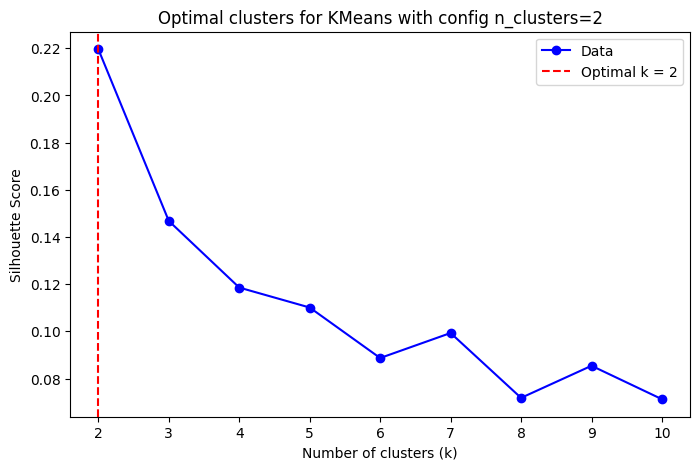

2025-01-09 21:32:50: INFO - Optimum number of clusters for 'authority' with 'KMeans': 2 using configuration: {'n_clusters': 2}
2025-01-09 21:32:50: INFO - Evaluating algorithm 2 of 8: 'GaussianMixture'
2025-01-09 21:32:50: INFO - Testing algorithm '<class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>' with parameters: {'n_components': 2}
2025-01-09 21:32:50: INFO - Testing algorithm '<class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>' with parameters: {'n_components': 3}
2025-01-09 21:32:50: INFO - Testing algorithm '<class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>' with parameters: {'n_components': 4}
2025-01-09 21:32:51: INFO - Testing algorithm '<class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>' with parameters: {'n_components': 5}
2025-01-09 21:32:51: INFO - Testing algorithm '<class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>' with parameters: {'n_components': 6}
2025-01-09 21:32:52: INFO - Testing algorithm '<class 'sklearn.mixture._g

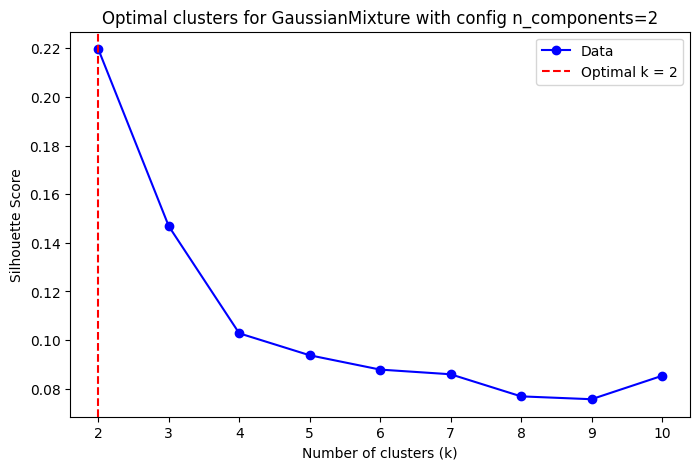

2025-01-09 21:32:56: INFO - Optimum number of clusters for 'authority' with 'GaussianMixture': 2 using configuration: {'n_components': 2}
2025-01-09 21:32:56: INFO - Evaluating algorithm 3 of 8: 'SpectralClustering'
2025-01-09 21:32:56: INFO - Testing algorithm '<class 'sklearn.cluster._spectral.SpectralClustering'>' with parameters: {'n_clusters': 2, 'affinity': 'nearest_neighbors'}
e:\source code\python\intensity\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
2025-01-09 21:32:56: INFO - Testing algorithm '<class 'sklearn.cluster._spectral.SpectralClustering'>' with parameters: {'n_clusters': 3, 'affinity': 'nearest_neighbors'}
e:\source code\python\intensity\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
2025-01-09 21:32:56: INFO - Te

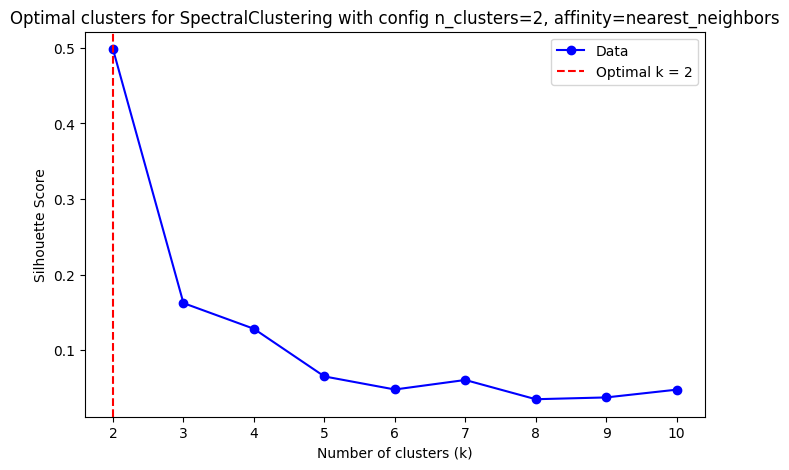

2025-01-09 21:32:57: INFO - Optimum number of clusters for 'authority' with 'SpectralClustering': 2 using configuration: {'n_clusters': 2, 'affinity': 'nearest_neighbors'}
2025-01-09 21:32:57: INFO - Evaluating algorithm 4 of 8: 'DBSCAN'
2025-01-09 21:32:57: INFO - Skipping 'DBSCAN' as it does not require finding the optimal number of clusters.
2025-01-09 21:32:57: INFO - Evaluating algorithm 5 of 8: 'OPTICS'
2025-01-09 21:32:57: INFO - Skipping 'OPTICS' as it does not require finding the optimal number of clusters.
2025-01-09 21:32:57: INFO - Evaluating algorithm 6 of 8: 'HDBSCAN'
2025-01-09 21:32:57: INFO - Skipping 'HDBSCAN' as it does not require finding the optimal number of clusters.
2025-01-09 21:32:57: INFO - Evaluating algorithm 7 of 8: 'MeanShift'
2025-01-09 21:32:57: INFO - Skipping 'MeanShift' as it does not require finding the optimal number of clusters.
2025-01-09 21:32:57: INFO - Evaluating algorithm 8 of 8: 'AffinityPropagation'
2025-01-09 21:32:57: INFO - Skipping 'Aff

Clustering algorithms and their parameters for optimal k determination
+--------------------+-----------+----------------------------------------------------+
|     Algorithm      | Optimal K |                     Parameters                     |
+--------------------+-----------+----------------------------------------------------+
|       KMeans       |     2     |                 {'n_clusters': 2}                  |
|  GaussianMixture   |     2     |                {'n_components': 2}                 |
| SpectralClustering |     2     | {'n_clusters': 2, 'affinity': 'nearest_neighbors'} |
+--------------------+-----------+----------------------------------------------------+


In [19]:
# Crear las carpetas donde almacenar los resultados del análisis del principio de persuasión actual
principle_path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)

logger.info(f"Creating folder '{principle_path}' for saving results of '{pop}'...")
if (not os.path.exists(principle_path)):
    os.makedirs(principle_path)
    logger.info(f"Folder '{principle_path}' created successfully.")
else:
    logger.info(f"Folder '{principle_path}' already exists.")

logger.info(f"Determining the optimum number of clusters for '{pop}'")

# Diccionario para almacenar el número óptimo de clusters por algoritmo
optimal_clusters = {}

# Preprocesamiento: Escalamiento de los datos
raw_data = embed_df.drop(columns=["id", "path"]).values
scaler = StandardScaler()
X = scaler.fit_transform(raw_data)

# Evaluación de cada algoritmo de clustering
total_algorithms = len(clustering_algorithms)
for index, (algorithm_name, algorithm_info) in enumerate(clustering_algorithms.items(), start=1):
    
    logger.info(f"Evaluating algorithm {index} of {total_algorithms}: '{algorithm_name}'")
    
    try:
        # Solo invocar 'find_optimal_k' si 'optimum_k' es True
        if algorithm_info['optimum_k']:
            optimal_k, best_params = find_optimal_k(
                X=X,
                algorithm_info=algorithm_info,  # Ahora se pasa el diccionario de parámetros de cada algoritmo
                export_path=principle_path
            )

            if optimal_k is not None:
                # Guardar el número óptimo y los parámetros en el diccionario
                optimal_clusters[algorithm_name] = {
                    'optimal_k': optimal_k,
                    'params': best_params  # Guardamos la configuración de los parámetros óptimos
                }

                logger.info(
                    f"Optimum number of clusters for '{pop}' with '{algorithm_name}': {optimal_k} "
                    f"using configuration: {best_params}"  # Incluimos los parámetros en el log
                )
        else:
            logger.info(f"Skipping '{algorithm_name}' as it does not require finding the optimal number of clusters.")

    except Exception as error:
        logger.error(f"Error processing '{algorithm_name}' for '{pop}': {error}")

logger.info("Optimum number of clusters completed!")

# Crear el DataFrame a partir del diccionario `optimal_clusters`
optimal_clusters_df = pd.DataFrame.from_dict(optimal_clusters, orient='index')

# Si quieres mostrar el DataFrame en forma de tabla, usa prettytable
# Crear un objeto PrettyTable
table = PrettyTable()

# Definir las columnas de la tabla según el DataFrame
table.field_names = ['Algorithm', 'Optimal K', 'Parameters']

# Rellenar la tabla con los valores del DataFrame
for algorithm, row in optimal_clusters_df.iterrows():
    table.add_row([algorithm, row['optimal_k'], row['params']])

print("Clustering algorithms and their parameters for optimal k determination")
# Mostrar la tabla
print(table)

**NOTE:** Although an automatic-analytical method for detecting the optimal number of groups is proposed here, it is up to the analyst to confirm or select a new optimal number of groups based on their expertise.

After the analytical method determines the optimal number of groups created, an interactive window is displayed for the analyst to confirm them.

In [20]:
optimal_clusters_df

,optimal_k,params
KMeans,2,{'n_clusters': 2}
GaussianMixture,2,{'n_components': 2}
SpectralClustering,2,"{'n_clusters': 2, 'affinity': 'nearest_neighbo..."


In [21]:
## Mostrar el DataFrame en una ventana interactiva
#gui = show(optimal_clusters_df)

## Después de hacer cambios en la GUI, obtén el DataFrame actualizado
#updated_data = gui.get_dataframes()["optimal_clusters_df"]  # Obtenemos el primer DataFrame modificado

## Mostrar el DataFrame actualizado
#print("Updated DataFrame:")
#updated_data = optimal_clusters_df

The optimal number of clusters confirmed by the analyst is displayed.

In [22]:
# Muestra el número óptimo de clusters para cada algoritmo y principio despuesde cerrar la GUI y haber confirmado (o actualizado) los valores 
# sugeridos por el metodo de detección del número óptimo de clusters.
updated_k = optimal_clusters_df
updated_k

,optimal_k,params
KMeans,2,{'n_clusters': 2}
GaussianMixture,2,{'n_components': 2}
SpectralClustering,2,"{'n_clusters': 2, 'affinity': 'nearest_neighbo..."


Once the optimal number of clusters has been determined, it should be updated in the configuration dictionary for the clustering algorithms (`clustering_algorithms`).


In [23]:
for algorithm, details in clustering_algorithms.items():
    if details['optimum_k'] and algorithm in updated_k.index:
        # Obtener el valor de k y los parámetros del DataFrame usando el índice (algoritmo)
        params_from_df = updated_k.loc[algorithm, 'params']
        if 'n_clusters' in params_from_df:
            details['optimal_k'] = params_from_df['n_clusters']
        elif 'n_components' in params_from_df:
            details['optimal_k'] = params_from_df['n_components']
        elif 'n_partitions' in params_from_df:
            details['optimal_k'] = params_from_df['n_partitions']
        # Actualizar los parámetros del diccionario con los del DataFrame
        details['params'] = params_from_df

# Crear la tabla PrettyTable
table = PrettyTable()
table.field_names = ["Algorithm", "Search for k?", "optimal k", "params"]

# Llenar la tabla con los valores del diccionario actualizado
for algorithm, details in clustering_algorithms.items():
    search_for_k = "Yes" if details['optimum_k'] else ""
    optimal_k = details.get('optimal_k', '')  # Si no hay valor, dejar vacío
    params = details['params']
    
    # Agregar la fila a la tabla
    table.add_row([algorithm, search_for_k, optimal_k, params])

# Mostrar la tabla
print(table)

+---------------------+---------------+-----------+----------------------------------------------------------------+
|      Algorithm      | Search for k? | optimal k |                             params                             |
+---------------------+---------------+-----------+----------------------------------------------------------------+
|        KMeans       |      Yes      |     2     |                       {'n_clusters': 2}                        |
|   GaussianMixture   |      Yes      |     2     |                      {'n_components': 2}                       |
|  SpectralClustering |      Yes      |     2     |       {'n_clusters': 2, 'affinity': 'nearest_neighbors'}       |
|        DBSCAN       |               |           | {'eps': [0.1, 0.2, 0.3, 0.5, 1.0], 'min_samples': [5, 10, 15]} |
|        OPTICS       |               |           |  {'min_samples': [5, 10, 15, 20], 'max_eps': [1.0, 1.5, 2.0]}  |
|       HDBSCAN       |               |           |             

In [24]:
# Ensure the folders exist
if not os.path.exists(RESULT_FOLDER):
    logger.error(f"Result folder '{RESULT_FOLDER}' not found.")
    raise FileNotFoundError(f"Result folder '{RESULT_FOLDER}' not found.")

# Build the file path
path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)
file_name = "clustering_algorithms_config.pkl"
file_path = os.path.join(path, file_name)

# Ensure the destination folder exists
if not os.path.exists(path):
    logger.info(f"The destination folder '{path}' does not exist. Creating the folder...")
    os.makedirs(path)

# Validate that the configuration dictionary is not empty
if not clustering_algorithms:
    logger.error("The 'clustering_algorithms' dictionary is empty. Cannot save the pickle file.")
    raise ValueError("The 'clustering_algorithms' dictionary is empty.")

# Try saving the dictionary as a pickle file
try:
    # Save the dictionary as a pickle file
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(clustering_algorithms, pickle_file)

    logger.info(f"Clustering algorithms and their configurations have been saved to '{file_path}' successfully!")
except Exception as e:
    logger.error(f"An error occurred while saving the pickle file: {e}")
    raise


2025-01-09 21:32:57: INFO - Clustering algorithms and their configurations have been saved to 'results\authority\clustering_algorithms_config.pkl' successfully!


The optimal number of clusters is then stored in a CSV file as confirmed by the user. If the user wishes to use the optimal parameters, they can load and apply these values.

In [25]:
# Check if the `updated_data` DataFrame is available
try:
    # Save the DataFrame to the CSV file
    output_path = os.path.join(path, "optimal_k_values.csv")
    logger.info(f"Saving the optimal number of clusters to `{output_path}`...")
    updated_k.to_csv(output_path, index=False)
    logger.info("File saved successfully.")
except NameError:
    logger.error("The `updated_data` DataFrame is not defined.")
except Exception as e:
    logger.error(f"Error saving the file: {e}")

2025-01-09 21:32:57: INFO - Saving the optimal number of clusters to `results\authority\optimal_k_values.csv`...
2025-01-09 21:32:57: INFO - File saved successfully.


## Clustering Data Using the Optimum Number of Clusters

Now that the optimal number of groups has been determined, the clustering of the data is performed using the pipeline, which evaluates all clustering algorithms with the previously selected optimal number of groups.

In [26]:
clustering_algorithms

{'KMeans': {'optimum_k': True,
  'class': sklearn.cluster._kmeans.KMeans,
  'params': {'n_clusters': 2},
  'optimal_k': 2},
 'GaussianMixture': {'optimum_k': True,
  'class': sklearn.mixture._gaussian_mixture.GaussianMixture,
  'params': {'n_components': 2},
  'optimal_k': 2},
 'SpectralClustering': {'optimum_k': True,
  'class': sklearn.cluster._spectral.SpectralClustering,
  'params': {'n_clusters': 2, 'affinity': 'nearest_neighbors'},
  'optimal_k': 2},
 'DBSCAN': {'optimum_k': False,
  'class': sklearn.cluster._dbscan.DBSCAN,
  'params': {'eps': [0.1, 0.2, 0.3, 0.5, 1.0], 'min_samples': [5, 10, 15]}},
 'OPTICS': {'optimum_k': False,
  'class': sklearn.cluster._optics.OPTICS,
  'params': {'min_samples': [5, 10, 15, 20], 'max_eps': [1.0, 1.5, 2.0]}},
 'HDBSCAN': {'optimum_k': False,
  'class': hdbscan.hdbscan_.HDBSCAN,
  'params': {'min_cluster_size': [5, 10, 15, 20]}},
 'MeanShift': {'optimum_k': False,
  'class': sklearn.cluster._mean_shift.MeanShift,
  'params': {}},
 'AffinityPro

It is necessary to compute the Silhouette Score for classification results of each algorithm

In [27]:
# Función para calcular el score de Silhouette
def calculate_silhouette(X, labels):
    if len(np.unique(labels)) > 1:  # Silhouette solo se calcula si hay más de 1 cluster
        return silhouette_score(X, labels)
    return -1

Ahora los datos son agrupados considerando todos los algoritmos de agrupamiento y sus diferentes configuraciones. La idea es obtener, por cada algoritmo, la configuración que mejores resultados de Silouette Score alcancen, en el entendido de que en tales algoritmos con tales configuraciones, los grupos obtenidos son lso que mejor calidad tienen. De esta manera, se espera verificar que en los grupos obtenidos la intensidad del principio de persuasion que se esta analizando tenga diferencias.

In [31]:
# Resultados
clustering_results = []

# X es el DataFrame de entrada (sin las columnas "id" y "path")
X = embed_df.drop(columns=["id", "path"]).values

# Aplicar StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
logger.info(f"Data shape after scaling: {X_scaled.shape}")

# Iteración sobre los algoritmos
for algo_name, algo_info in clustering_algorithms.items():
    logger.info(f"Comenzando con el algoritmo: {algo_name}")
    algo_class = algo_info['class']
    algo_params = algo_info['params']

    # Filtrar parámetros constantes (asegurar que todos los parámetros sean listas)
    algo_params = {k: v if isinstance(v, list) else [v] for k, v in algo_params.items()}
    param_combinations = list(product(*algo_params.values()))
    logger.info(f"Combinaciones de parámetros generadas: {len(param_combinations)} combinaciones")

    for i, params in enumerate(param_combinations, start=1):
        param_dict = dict(zip(algo_params.keys(), params))  # Crear diccionario a partir de las combinaciones
        logger.info(f"Ejecutando {i} de {len(param_combinations)} con los parámetros: {param_dict}")

        try:
            model = algo_class(**param_dict)
            model.fit(X_scaled)
            labels = model.labels_ if hasattr(model, 'labels_') else model.predict(X_scaled)
            
            ## Representando los grupos obtenidos       
            #pca = PCA(n_components=2)  # Reducir a 2 dimensiones (puedes ajustar este valor)
            #X_pca = pca.fit_transform(X_scaled)
            #X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
            
            ## Construir el título del gráfico y el nombre del archivo usando la mejor configuración de parámetros
            #params_str = ', '.join([f"{key}={value}" for key, value in param_dict.items()])
            
            ## Obtener el Silhouette Score
            silhouette_values = calculate_silhouette(X_scaled, labels)
            
            #plot_title = f'Clusters para {algo_name} usando {params_str} y Silhouette Score: {silhouette_values:.2f}'
            
            #export_path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)  
            
            ## Sanitizar el plot_title para asegurarse de que no contenga caracteres no válidos
            #sanitized_plot_title = re.sub(r'[\\/*?:"<>|]', "_", plot_title)  # Reemplaza caracteres no válidos por "_"

            ## Usar os.path.join para asegurarse de que la ruta es correcta
            #plot_file_name = os.path.join(export_path, sanitized_plot_title).replace(" ", "_") + ".png"
        
            ## Construir la nota con todos los detalles del algoritmo
            #num_clusters = len(set(labels))  # Número de grupos
            #note = f"Detalles del Algoritmo {algo_name}:\n" \
            #    f"Parámetros: {params_str}\n" \
            #    f"Silhouette Score: {silhouette_values:.2f}\n" \
            #    f"Número de grupos: {num_clusters}\n"
        
            ## Crear un gráfico de dispersión con los clusters
            #plot_point_chart(X_pca_df["PC1"].to_list(), X_pca_df["PC2"].to_list(), labels, 
            #        title=plot_title,
            #        x_label='Principal Component 1', 
            #        y_label='Principal Component 2', 
            #        file_path=file_path,
            #        note=note)

            # Guardar resultados
            clustering_results.append({
                'algorithm': algo_name,
                'params': param_dict,
                'silhouette_score': silhouette_values,
                'model': model
            })

        except Exception as e:
            logger.error(f"Error en algoritmo {algo_name} con parámetros {param_dict}. Detalles: {str(e)}.")

# Crear un DataFrame a partir de los resultados
result_df = pd.DataFrame(clustering_results)
result_df


2025-01-09 21:38:23: INFO - Data shape after scaling: (598, 768)
2025-01-09 21:38:23: INFO - Comenzando con el algoritmo: KMeans
2025-01-09 21:38:23: INFO - Combinaciones de parámetros generadas: 1 combinaciones
2025-01-09 21:38:23: INFO - Ejecutando 1 de 1 con los parámetros: {'n_clusters': 2}


2025-01-09 21:38:23: INFO - Comenzando con el algoritmo: GaussianMixture
2025-01-09 21:38:23: INFO - Combinaciones de parámetros generadas: 1 combinaciones
2025-01-09 21:38:23: INFO - Ejecutando 1 de 1 con los parámetros: {'n_components': 2}
2025-01-09 21:38:23: INFO - Comenzando con el algoritmo: SpectralClustering
2025-01-09 21:38:23: INFO - Combinaciones de parámetros generadas: 1 combinaciones
2025-01-09 21:38:23: INFO - Ejecutando 1 de 1 con los parámetros: {'n_clusters': 2, 'affinity': 'nearest_neighbors'}
e:\source code\python\intensity\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
2025-01-09 21:38:23: INFO - Comenzando con el algoritmo: DBSCAN
2025-01-09 21:38:23: INFO - Combinaciones de parámetros generadas: 15 combinaciones
2025-01-09 21:38:23: INFO - Ejecutando 1 de 15 con los parámetros: {'eps': 0.1, 'min_samples': 5}
2025-01-09 21:38:23: INFO - Ej

,algorithm,params,silhouette_score,model
0,KMeans,{'n_clusters': 2},0.219602,KMeans(n_clusters=2)
1,GaussianMixture,{'n_components': 2},0.219602,GaussianMixture(n_components=2)
2,SpectralClustering,"{'n_clusters': 2, 'affinity': 'nearest_neighbo...",0.498208,SpectralClustering(affinity='nearest_neighbors...
3,DBSCAN,"{'eps': 0.1, 'min_samples': 5}",-1.000000,DBSCAN(eps=0.1)
4,DBSCAN,"{'eps': 0.1, 'min_samples': 10}",-1.000000,"DBSCAN(eps=0.1, min_samples=10)"
5,DBSCAN,"{'eps': 0.1, 'min_samples': 15}",-1.000000,"DBSCAN(eps=0.1, min_samples=15)"
6,DBSCAN,"{'eps': 0.2, 'min_samples': 5}",-1.000000,DBSCAN(eps=0.2)
7,DBSCAN,"{'eps': 0.2, 'min_samples': 10}",-1.000000,"DBSCAN(eps=0.2, min_samples=10)"
8,DBSCAN,"{'eps': 0.2, 'min_samples': 15}",-1.000000,"DBSCAN(eps=0.2, min_samples=15)"
9,DBSCAN,"{'eps': 0.3, 'min_samples': 5}",-1.000000,DBSCAN(eps=0.3)


Una vez que se obtienen todas las combinaciones, se muestran los resultados. Las combinaciones se guardan en `clustering_results`.

+---------------------+---------+----------------------------------------------------+---------+----------------------------------------------------+---------+--------+--------+--------------+--------------+
|      Algorithm      |   Min   |                     Param_Min                      |   Max   |                     Param_Max                      |   Mean  |  Std   |  Var   | Min_Clusters | Max_Clusters |
+---------------------+---------+----------------------------------------------------+---------+----------------------------------------------------+---------+--------+--------+--------------+--------------+
|        KMeans       |  0.2196 |                 {'n_clusters': 2}                  |  0.2196 |                 {'n_clusters': 2}                  |  0.2196 | 0.0000 | 0.0000 |      2       |      2       |
|   GaussianMixture   |  0.2196 |                {'n_components': 2}                 |  0.2196 |                {'n_components': 2}                 |  0.2196 | 0.0000 |

C:\Users\lbust\AppData\Local\Temp\ipykernel_10200\1735494526.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(algorithm_stats))  # Genera una paleta de colores


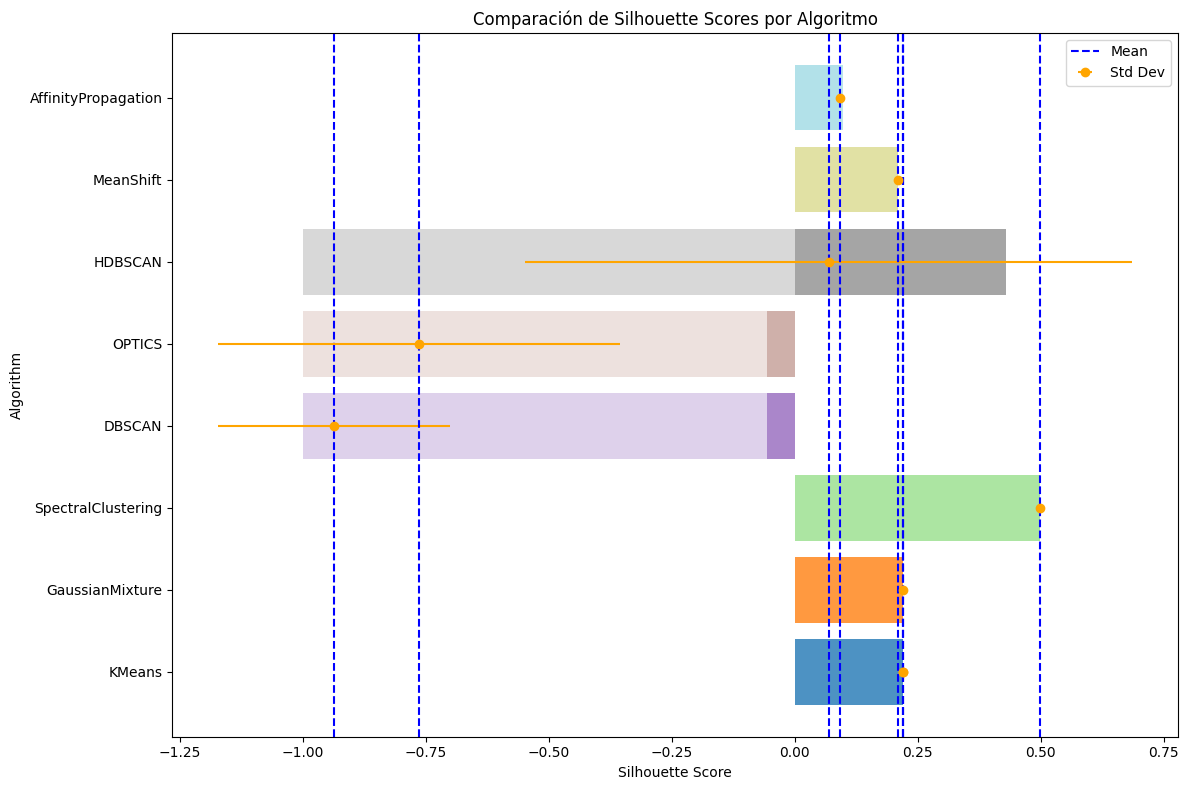

In [32]:
# Inicializar un diccionario para almacenar los resultados de cada algoritmo
algorithm_stats = {}

# Función para obtener el número de clusters de un modelo
def get_num_clusters(model):
    # Para GaussianMixture, el número de componentes (clusters) se encuentra en 'n_components_'
    if isinstance(model, GaussianMixture):
        # Asegurarse de que el modelo ha sido ajustado antes de acceder a n_components_
        if hasattr(model, 'n_components_'):
            return model.n_components_

    # Intentamos obtener 'n_clusters_' si está disponible
    elif hasattr(model, 'n_clusters_'):
        return model.n_clusters_
    # Si no está disponible, intentamos con el número de etiquetas (por ejemplo, DBSCAN)
    elif hasattr(model, 'labels_'):
        return len(np.unique(model.labels_))  # El número de clusters es el número de etiquetas únicas
    else:
        return None  # Si no podemos obtener el número de clusters, retornamos None

# Procesar los resultados
for algo_name in result_df['algorithm'].unique():
    # Filtrar los resultados por algoritmo
    algo_results = result_df[result_df['algorithm'] == algo_name]
    
    # Obtener los valores de silhouette score y sus configuraciones de parámetros
    silhouette_scores = algo_results['silhouette_score'].values
    params = algo_results['params'].apply(lambda x: str(x)).values  # Convertir a string para mejor visualización
    
    # Calcular estadísticas
    min_score = np.min(silhouette_scores)
    max_score = np.max(silhouette_scores)
    mean_score = np.mean(silhouette_scores)
    std_score = np.std(silhouette_scores)
    var_score = np.var(silhouette_scores)
    
    # Obtener los parámetros correspondientes al mínimo y al máximo
    min_param = params[np.argmin(silhouette_scores)]  # Parametro con el mínimo
    max_param = params[np.argmax(silhouette_scores)]  # Parametro con el máximo
    
    # Obtener el modelo correspondiente al mínimo y máximo Silhouette Score
    min_model = algo_results.iloc[np.argmin(silhouette_scores)]['model']
    max_model = algo_results.iloc[np.argmax(silhouette_scores)]['model']
    
    # Obtener el número de clusters para el modelo con el mejor y peor Silhouette Score
    min_clusters = get_num_clusters(min_model)
    max_clusters = get_num_clusters(max_model)
    
    # Almacenar las estadísticas
    algorithm_stats[algo_name] = {
        'min': min_score,
        'max': max_score,
        'mean': mean_score,
        'std': std_score,
        'var': var_score,
        'min_param': min_param,  # Guardamos los parámetros del mínimo
        'max_param': max_param,  # Guardamos los parámetros del máximo
        'min_clusters': min_clusters,  # Añadir número de grupos en el mínimo
        'max_clusters': max_clusters,  # Añadir número de grupos en el máximo
        'scores': silhouette_scores  # Guardamos los valores de los scores
    }

# Crear una tabla vacía
table = PrettyTable()

# Definir las columnas de la tabla
table.field_names = ["Algorithm", "Min", "Param_Min", "Max", "Param_Max", "Mean", "Std", "Var", "Min_Clusters", "Max_Clusters"]

# Agregar las filas con los resultados
for algo_name, stats in algorithm_stats.items():
    table.add_row([
        algo_name,
        f"{stats['min']:.4f}",
        stats['min_param'],  # Agregar los parámetros del mínimo
        f"{stats['max']:.4f}",
        stats['max_param'],  # Agregar los parámetros del máximo
        f"{stats['mean']:.4f}",
        f"{stats['std']:.4f}",
        f"{stats['var']:.4f}",
        stats['min_clusters'] if stats['min_clusters'] is not None else 'N/A',  # Mostrar 'N/A' si no se puede obtener
        stats['max_clusters'] if stats['max_clusters'] is not None else 'N/A'   # Mostrar 'N/A' si no se puede obtener
    ])

# Imprimir la tabla
print(table)

# Crear una visualización
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))

# Usar un mapa de colores de matplotlib
cmap = cm.get_cmap('tab20', len(algorithm_stats))  # Genera una paleta de colores

# Iterar sobre los algoritmos y representar los resultados
for i, (algo_name, stats) in enumerate(algorithm_stats.items()):
    # Tomar los valores de cada algoritmo
    min_score = stats['min']
    max_score = stats['max']
    mean_score = stats['mean']
    std_score = stats['std']
    var_score = stats['var']
    silhouette_scores = stats['scores']
    
    # Obtener un color único para el algoritmo
    color = cmap(i)
    
    # Crear un gráfico de barras para cada algoritmo
    ax.barh(algo_name, max_score, color=color, alpha=0.7)  # Máximo en un color único
    ax.barh(algo_name, min_score, color=color, alpha=0.3)  # Mínimo en un color más tenue
    
    # Plotear la media (línea azul)
    ax.axvline(mean_score, color='blue', linestyle='--')  # Media en azul
    
    # Agregar desviación estándar (sombras)
    ax.errorbar(mean_score, algo_name, xerr=std_score, fmt='o', color='orange')

    # Añadir las etiquetas de la leyenda solo una vez
    if i == 0:
        ax.axvline(mean_score, color='blue', linestyle='--', label='Mean')
        ax.errorbar(mean_score, algo_name, xerr=std_score, fmt='o', color='orange', label='Std Dev')

# Agregar etiquetas
ax.set_xlabel('Silhouette Score')
ax.set_ylabel('Algorithm')
ax.set_title('Comparación de Silhouette Scores por Algoritmo')

# Añadir leyenda
ax.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Ahora debo quedarme con lso parametros que mejores resultados de Silhouette Score alcancen pro  todos lso algoritmos para agrupar los datos de acuerdo cone llos.

In [33]:
# Crear un diccionario para almacenar los mejores parámetros de cada algoritmo
best_parameters = {}

# Procesar los resultados para obtener el mejor Silhouette Score y sus parámetros
for algo_name in result_df['algorithm'].unique():
    # Filtrar los resultados por algoritmo
    algo_results = result_df[result_df['algorithm'] == algo_name]
    
    # Obtener los valores de silhouette score y sus configuraciones de parámetros
    silhouette_scores = algo_results['silhouette_score'].values
    params = algo_results['params'].apply(lambda x: str(x)).values  # Convertir a string para mejor visualización
    
    # Obtener el parámetro correspondiente al máximo silhouette score
    max_score = np.max(silhouette_scores)
    max_param = params[np.argmax(silhouette_scores)]  # Parametro con el máximo score
    
    # Almacenar el mejor parámetro y su silhouette score en el diccionario
    best_parameters[algo_name] = {
        'params': max_param,
        'silhouette_score': max_score
    }

# Imprimir el diccionario de los mejores parámetros
print(best_parameters)

{'KMeans': {'params': "{'n_clusters': 2}", 'silhouette_score': np.float64(0.21960178017616272)}, 'GaussianMixture': {'params': "{'n_components': 2}", 'silhouette_score': np.float64(0.21960178017616272)}, 'SpectralClustering': {'params': "{'n_clusters': 2, 'affinity': 'nearest_neighbors'}", 'silhouette_score': np.float64(0.49820828437805176)}, 'DBSCAN': {'params': "{'eps': 1.0, 'min_samples': 5}", 'silhouette_score': np.float64(-0.05688098818063736)}, 'OPTICS': {'params': "{'min_samples': 5, 'max_eps': 1.0}", 'silhouette_score': np.float64(-0.05688098818063736)}, 'HDBSCAN': {'params': "{'min_cluster_size': 5}", 'silhouette_score': np.float64(0.42932450771331787)}, 'MeanShift': {'params': '{}', 'silhouette_score': np.float64(0.20961689949035645)}, 'AffinityPropagation': {'params': "{'damping': 0.5}", 'silhouette_score': np.float64(0.09773580729961395)}}


In [34]:
embed_df

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,id,path
0,0.096209,0.152683,0.193249,0.016189,0.375132,-0.261907,0.125467,0.432013,-0.001726,-0.183225,...,0.155682,-0.306354,-0.080521,-0.177477,0.060439,-0.067538,-0.099230,0.109578,9762,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
1,-0.072205,0.067802,0.357244,0.037719,0.436252,-0.128882,0.049326,0.316047,-0.004852,-0.207884,...,0.170035,-0.258228,-0.156399,-0.067954,-0.057610,-0.112407,-0.168488,0.082323,9763,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
2,0.065490,0.073135,0.303711,-0.038981,0.392661,-0.142789,0.082904,0.269112,0.076318,-0.158853,...,0.119092,-0.134415,-0.093278,-0.098334,0.042149,-0.130044,-0.097641,0.036647,9764,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
3,0.126272,0.011344,0.367267,0.083592,0.449823,-0.145410,0.080765,0.221521,0.057800,-0.145011,...,0.005316,-0.198921,-0.065224,0.068022,-0.140596,-0.091489,-0.092740,0.164466,9766,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
4,0.184803,-0.030021,0.378522,0.010510,0.349926,-0.026439,0.058939,0.317805,0.040234,-0.133832,...,0.027804,-0.183020,0.023366,0.049959,-0.101701,-0.050186,-0.116499,0.137569,9767,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,0.150477,0.185594,0.334257,-0.059043,0.180246,-0.075516,0.097333,0.352394,0.109118,-0.154295,...,0.087740,-0.225297,0.070205,-0.127896,-0.144014,0.096931,-0.088158,0.113249,5690,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
594,0.234969,-0.043283,0.306206,0.148112,0.331764,-0.168138,0.072470,0.326924,0.058873,-0.193668,...,0.004664,-0.124429,0.155290,0.115657,-0.124182,0.032871,-0.129683,0.066232,5691,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
595,0.105826,0.124749,0.355753,0.108981,0.347319,-0.225326,0.203359,0.278280,0.142702,-0.296989,...,0.068012,-0.220056,-0.091292,0.096117,-0.021350,-0.024908,-0.102940,0.102136,5693,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
596,0.052480,0.092560,0.231235,-0.095931,0.295719,-0.077306,0.086920,0.346897,0.087620,0.006324,...,0.134313,-0.242091,-0.044011,-0.053774,0.101083,-0.054767,-0.137243,0.216108,5697,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...


2025-01-09 21:39:38: INFO - Data shape for principle: (598, 768)
2025-01-09 21:39:38: INFO - Running 'KMeans' with parameters: {'n_clusters': 2}. Algorithm 1 of 8
2025-01-09 21:39:38: INFO - Chart saved at: 'results\authority\KMeans_clusters.png'


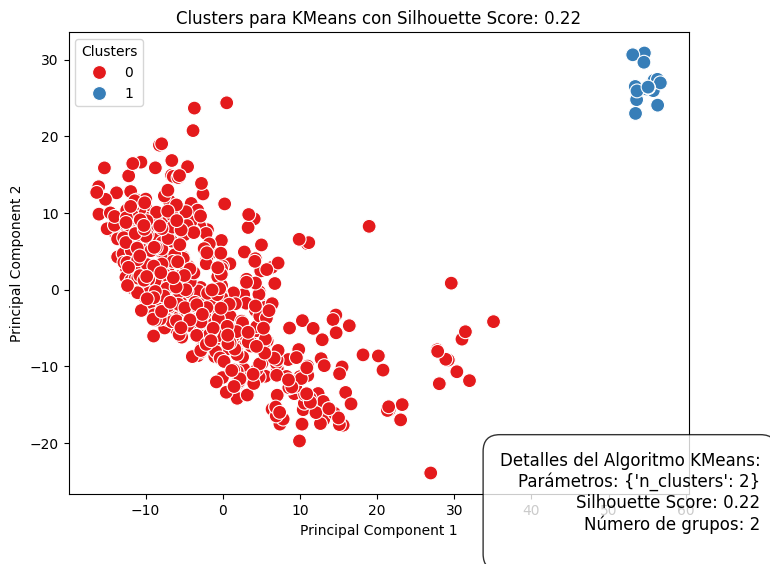

2025-01-09 21:39:38: INFO - Finished clustering with 'KMeans'. Clusters saved as 'KMeans (0.22)'.
2025-01-09 21:39:38: INFO - Running 'GaussianMixture' with parameters: {'n_components': 2}. Algorithm 2 of 8
2025-01-09 21:39:39: INFO - Chart saved at: 'results\authority\GaussianMixture_clusters.png'


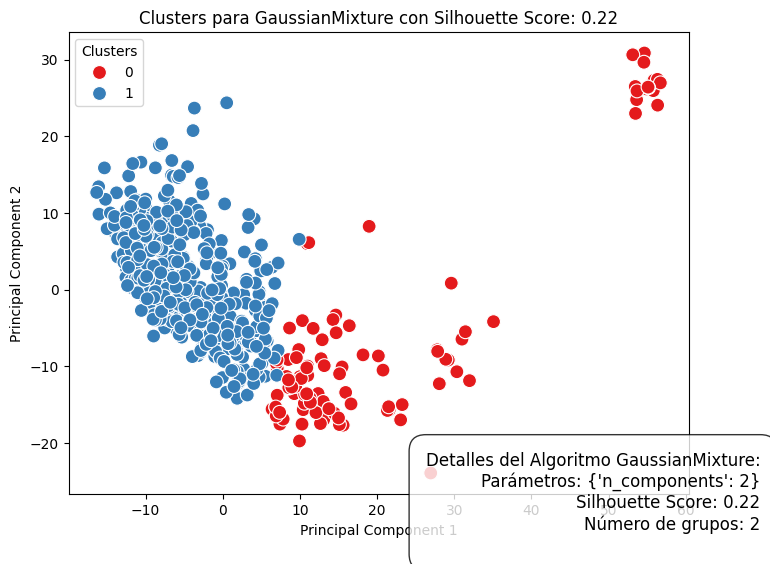

2025-01-09 21:39:39: INFO - Finished clustering with 'GaussianMixture'. Clusters saved as 'GaussianMixture (0.22)'.
2025-01-09 21:39:39: INFO - Running 'SpectralClustering' with parameters: {'n_clusters': 2, 'affinity': 'nearest_neighbors'}. Algorithm 3 of 8
e:\source code\python\intensity\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
2025-01-09 21:39:39: INFO - Chart saved at: 'results\authority\SpectralClustering_clusters.png'


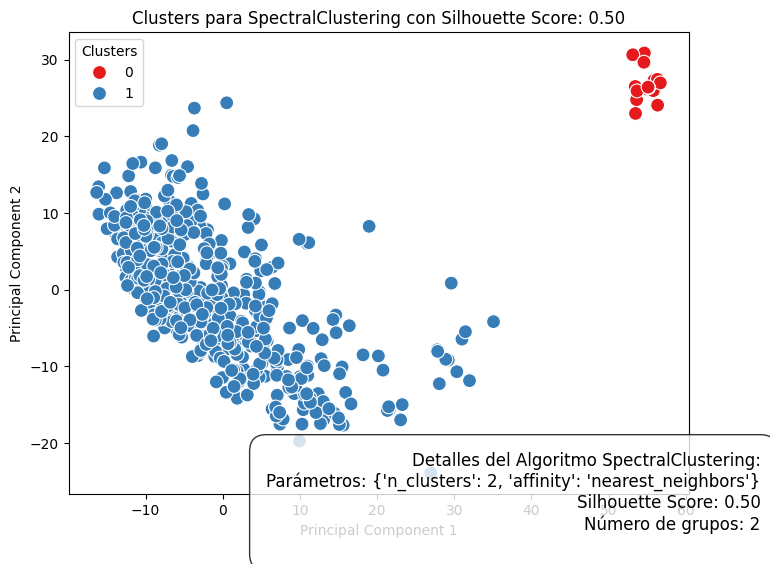

2025-01-09 21:39:39: INFO - Finished clustering with 'SpectralClustering'. Clusters saved as 'SpectralClustering (0.50)'.
2025-01-09 21:39:39: INFO - Running 'DBSCAN' with parameters: {'eps': 1.0, 'min_samples': 5}. Algorithm 4 of 8
2025-01-09 21:39:39: INFO - Chart saved at: 'results\authority\DBSCAN_clusters.png'


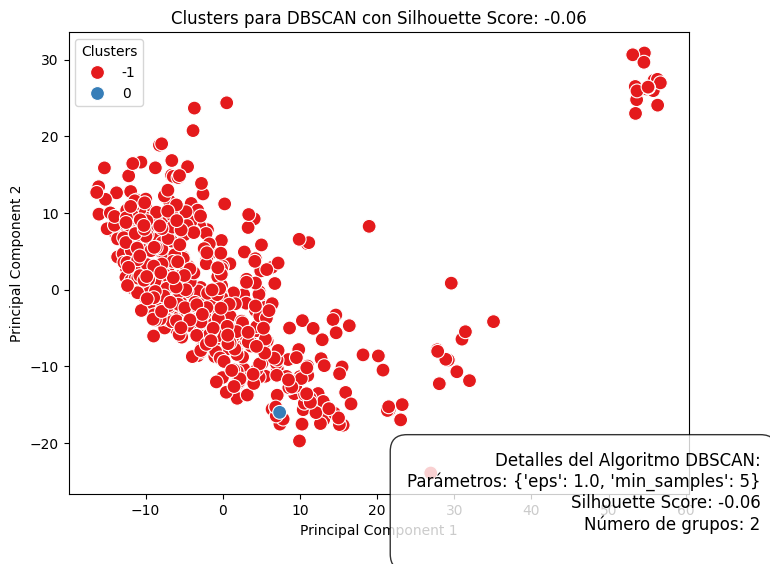

2025-01-09 21:39:39: INFO - Finished clustering with 'DBSCAN'. Clusters saved as 'DBSCAN (-0.06)'.
2025-01-09 21:39:39: INFO - Running 'OPTICS' with parameters: {'min_samples': 5, 'max_eps': 1.0}. Algorithm 5 of 8
2025-01-09 21:39:40: INFO - Chart saved at: 'results\authority\OPTICS_clusters.png'


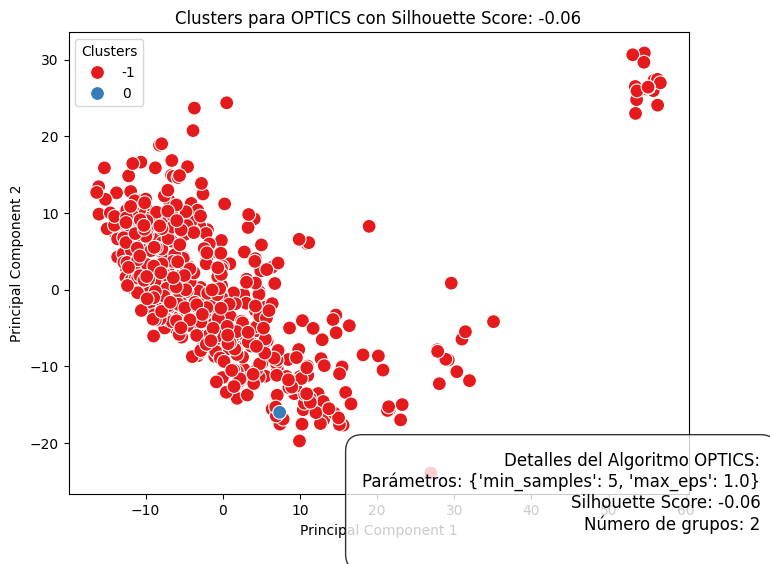

2025-01-09 21:39:40: INFO - Finished clustering with 'OPTICS'. Clusters saved as 'OPTICS (-0.06)'.
2025-01-09 21:39:40: INFO - Running 'HDBSCAN' with parameters: {'min_cluster_size': 5}. Algorithm 6 of 8
2025-01-09 21:39:40: INFO - Chart saved at: 'results\authority\HDBSCAN_clusters.png'


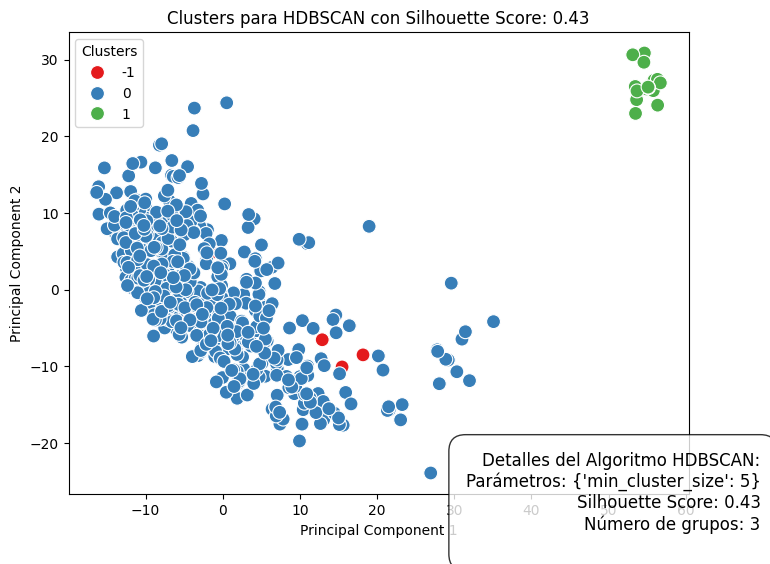

2025-01-09 21:39:40: INFO - Finished clustering with 'HDBSCAN'. Clusters saved as 'HDBSCAN (0.43)'.
2025-01-09 21:39:40: INFO - Running 'MeanShift' with parameters: {}. Algorithm 7 of 8
2025-01-09 21:40:29: INFO - Chart saved at: 'results\authority\MeanShift_clusters.png'


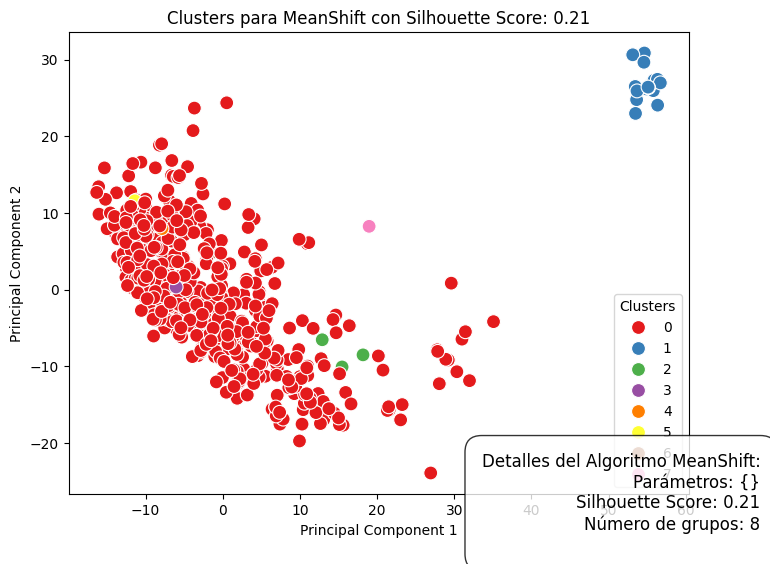

2025-01-09 21:40:30: INFO - Finished clustering with 'MeanShift'. Clusters saved as 'MeanShift (0.21)'.
2025-01-09 21:40:30: INFO - Running 'AffinityPropagation' with parameters: {'damping': 0.5}. Algorithm 8 of 8
2025-01-09 21:40:30: INFO - Chart saved at: 'results\authority\AffinityPropagation_clusters.png'


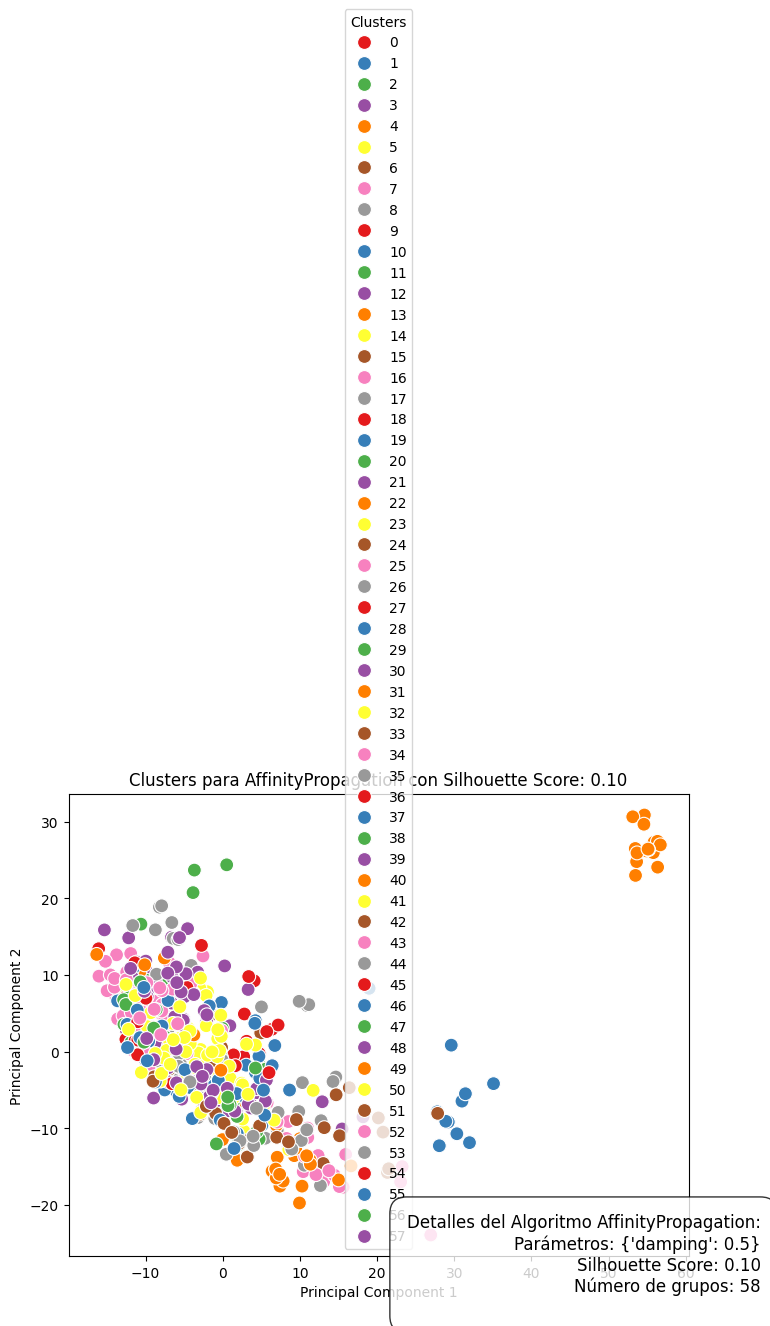

2025-01-09 21:40:30: INFO - Finished clustering with 'AffinityPropagation'. Clusters saved as 'AffinityPropagation (0.10)'.


,0,1,2,3,4,5,6,7,8,9,...,id,path,KMeans (0.22),GaussianMixture (0.22),SpectralClustering (0.50),DBSCAN (-0.06),OPTICS (-0.06),HDBSCAN (0.43),MeanShift (0.21),AffinityPropagation (0.10)
0,0.096209,0.152683,0.193249,0.016189,0.375132,-0.261907,0.125467,0.432013,-0.001726,-0.183225,...,9762,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,1,-1,-1,0,0,13
1,-0.072205,0.067802,0.357244,0.037719,0.436252,-0.128882,0.049326,0.316047,-0.004852,-0.207884,...,9763,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,1,-1,-1,0,0,13
2,0.065490,0.073135,0.303711,-0.038981,0.392661,-0.142789,0.082904,0.269112,0.076318,-0.158853,...,9764,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,1,1,-1,-1,0,0,17
3,0.126272,0.011344,0.367267,0.083592,0.449823,-0.145410,0.080765,0.221521,0.057800,-0.145011,...,9766,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,1,1,-1,-1,0,0,14
4,0.184803,-0.030021,0.378522,0.010510,0.349926,-0.026439,0.058939,0.317805,0.040234,-0.133832,...,9767,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,1,1,-1,-1,0,0,7


In [35]:
# Crear un nuevo DataFrame para almacenar los clusters
clustered_df = embed_df.copy()

# X es el DataFrame de entrada (sin las columnas "id" y "path")
X = embed_df.drop(columns=["id", "path"]).values

# Aplicar StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logger.info(f"Data shape for principle: {X_scaled.shape}")

# Iterar sobre los algoritmos y aplicar cada uno
for index, (algorithm_name, details) in enumerate(best_parameters.items(), start=1):
    try:
        # Obtener parámetros y Silhouette Score
        params = eval(details['params'])  # Convertir de string a dict
        silhouette_score = details['silhouette_score']

        # Mostrar progreso
        logger.info(f"Running '{algorithm_name}' with parameters: {params}. Algorithm {index} of {len(best_parameters)}")

        # Obtener la clase del algoritmo desde clustering_algorithms
        algo_class = clustering_algorithms.get(algorithm_name, {}).get('class')
        if algo_class is None:
            logger.warning(f"Algorithm '{algorithm_name}' not recognized in clustering_algorithms. Skipping.")
            continue

        # Inicializar el modelo con los mejores parámetros
        model = algo_class(**params)

        # Ajustar el modelo y obtener los clusters
        if hasattr(model, 'fit_predict'):  # Algunos modelos tienen fit_predict directamente
            clusters = model.fit_predict(X_scaled)  # Usar X escalado
        else:  # Otros requieren fit seguido de predict
            model.fit(X_scaled)
            clusters = model.predict(X_scaled)
            
        # Representando los grupos obtenidos       
        pca = PCA(n_components=2)  # Reducir a 2 dimensiones (puedes ajustar este valor)
        X_pca = pca.fit_transform(X_scaled)
        X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        
        file_name = f"{algorithm_name}_clusters.png"
        file_path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER, file_name)        
        
        # Construir la nota con todos los detalles del algoritmo
        num_clusters = len(set(clusters))  # Número de grupos
        note = f"Detalles del Algoritmo {algorithm_name}:\n" \
               f"Parámetros: {params}\n" \
               f"Silhouette Score: {silhouette_score:.2f}\n" \
               f"Número de grupos: {num_clusters}\n"
        
        # Crear un gráfico de dispersión con los clusters
        plot_point_chart(X_pca_df["PC1"].to_list(), X_pca_df["PC2"].to_list(), clusters, 
                 title=f'Clusters para {algorithm_name} con Silhouette Score: {silhouette_score:.2f}',
                 x_label='Principal Component 1', 
                 y_label='Principal Component 2', 
                 file_path=file_path,
                 note=note)

        # Agregar los clusters al DataFrame
        column_name = f"{algorithm_name} ({silhouette_score:.2f})"
        clustered_df[column_name] = clusters
        
        logger.info(f"Finished clustering with '{algorithm_name}'. Clusters saved as '{column_name}'.")

    except Exception as e:
        logger.error(f"Error applying {algorithm_name}: {e}")

# Mostrar las primeras filas del DataFrame con clusters
clustered_df.head()


este es el codigo origonal

## Data labeling considering clusters obtained

Assigning labels detected by each algorithm to the original data. Using this, the text of the messages in each group can be obtained, allowing for deeper analysis.

In [ ]:
# Crear una copia de embed_df para asegurarnos de no modificar los datos originales
embed_df_updated = embed_df.copy()

# Iterar sobre cada principio y sus resultados en cluster_results
for principle, algo_results in cluster_results.items():
    logger.info(f"Updating embed_df for principle '{principle}'")

    for algo_name, algo_data in algo_results.items():
        # Verificar que 'id' y 'labels' existen en los datos del algoritmo
        if (("id" not in algo_data) or ("labels" not in algo_data)):
            logger.error(f"Missing 'id' or 'labels' in cluster_results for algorithm '{algo_name}' and principle '{principle}'")
            continue

        # Crear un diccionario para mapear ID a su respectiva etiqueta
        id_to_label = dict(zip(algo_data["id"], algo_data["labels"]))

        # Agregar una nueva columna al DataFrame con las etiquetas del algoritmo
        # Si un ID no está en el resultado del algoritmo, se asignará NaN
        embed_df_updated[f"{algo_name.upper()}"] = embed_df_updated["id"].map(id_to_label)

# Realizar un merge de embed_df_updated con data_df usando la columna 'id' como clave
embed_df_updated = embed_df_updated.merge(data_df[['id', 'txt', 'subject']], on='id', how='left')

logger.info("Data has been successfully updated with clustering labels.")
embed_df_updated.head()


Saving data updated with cluster labels for each algorithm.

**NOTE:** This was tested using only one principle of persuasion (authority). When this code is deployed to handle multiple principles of persuasion, it might fail. This should be considered to update the data structures used and avoid errors.

In [ ]:
# Guardar el DataFrame actualizado en un archivo CSV
path = "results/data_clustered.csv"
embed_df_updated.to_csv(path, index=False)

logger.info(f"Updated DataFrame has been saved to '{path}'.")

## Measuring the intensity of each principle of persuasion in clusters.

At this point, I have for each persuasion principle the analysis of several clustering algorithms and an evaluation of the quality of the resulting groups. Now, for each principle, the best clustering algorithm must be identified, and from this point forward, each principle will be worked with the identified algorithm. This helps reduce the number of tests, although it does not rule out the possibility of conducting other checks.

# TRASH

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Obtener los centros de los clusters
cluster_centers = kmeans.cluster_centers_

# Calcular la distancia de cada mensaje al centro del clúster al que pertenece
distances = euclidean_distances(embeddings, cluster_centers)

# Asignar la intensidad basada en la distancia
# Normalización de la distancia a una escala de 1 a 10
max_distance = np.max(distances)
min_distance = np.min(distances)

intensities = 10 * (1 - (distances - min_distance) / (max_distance - min_distance))


# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Text': data_authority["txt"].tolist(),  # Asegúrate de tener el DataFrame con tus datos
    'Intensity': [intensities[i].max() for i in range(len(intensities))],  # Intensidad calculada
    'Cluster': kmeans.labels_  # Clúster asignado
})

# Mostrar el DataFrame resultante
results

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Calcular las distancias a los centros de los clústeres
distances_to_centers = np.linalg.norm(embeddings - kmeans.cluster_centers_[kmeans.labels_], axis=1)

# Normalizar las distancias a la escala de 1 a 10
scaler = MinMaxScaler(feature_range=(1, 10))
distances_normalized = scaler.fit_transform(distances_to_centers.reshape(-1, 1))

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Text': data_authority["txt"].tolist(),  # Asegúrate de tener el DataFrame con tus datos
    'Intensity': distances_normalized.flatten(),  # Intensidad calculada
    'Cluster': kmeans.labels_  # Clúster asignado
})

# Calcular el rango de intensidad para cada grupo
cluster_ranges = {}
for cluster in np.unique(kmeans.labels_):
    # Obtener las intensidades para el clúster
    intensities_for_cluster = results[results['Cluster'] == cluster]['Intensity']
    min_intensity = intensities_for_cluster.min()
    max_intensity = intensities_for_cluster.max()
    
    # Asignar el rango de intensidad al clúster
    cluster_ranges[cluster] = (min_intensity, max_intensity)

# Asignar el rango de intensidad a cada texto
def get_intensity_range(cluster):
    min_intensity, max_intensity = cluster_ranges[cluster]
    return f"Grupo {cluster + 1}, intensidad de {min_intensity:.2f} a {max_intensity:.2f}"

results['Intensity Range'] = results['Cluster'].apply(get_intensity_range)

# Mostrar el DataFrame resultante
results


In [ ]:
# Calcular el promedio, varianza y desviación estándar para cada grupo (clúster)
group_stats = results.groupby('Cluster')['Intensity'].agg(
    ['mean', 'var', 'std']
).reset_index()

# Mostrar las estadísticas de los grupos
group_stats

In [ ]:
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# Calcular el promedio, varianza y desviación estándar para cada grupo (clúster)
group_stats = results.groupby('Cluster')['Intensity'].agg(
    ['mean', 'var', 'std']
).reset_index()

# Mostrar las estadísticas de los grupos
print(group_stats)

# Calcular el índice de silueta para el modelo de clustering
sil_score = silhouette_score(embeddings, kmeans.labels_)
print(f"Silhouette Score: {sil_score:.3f}")

# Calcular la cohesión: distancia intra-clúster (dentro de cada clúster)
cohesion = np.sum([np.sum(np.linalg.norm(embeddings[kmeans.labels_ == i] - kmeans.cluster_centers_[i], axis=1)) for i in range(kmeans.n_clusters)])

# Calcular la separación: distancia entre los centros de los clústeres
separation = np.sum([np.linalg.norm(kmeans.cluster_centers_[i] - kmeans.cluster_centers_[j]) for i in range(kmeans.n_clusters) for j in range(i + 1, kmeans.n_clusters)])

print(f"Cohesión: {cohesion:.2f}")
print(f"Separación: {separation:.2f}")


In [ ]:
from sklearn.metrics import silhouette_samples
import numpy as np
import pandas as pd

# Calcular el índice de silueta para cada punto
silhouette_values = silhouette_samples(embeddings, kmeans.labels_)

# Asignar el índice de silueta promedio por grupo
silhouette_scores = []
for cluster in np.unique(kmeans.labels_):
    cluster_silhouette = silhouette_values[kmeans.labels_ == cluster]
    silhouette_scores.append((cluster, np.mean(cluster_silhouette)))

# Mostrar los resultados
silhouette_df = pd.DataFrame(silhouette_scores, columns=["Cluster", "Average Silhouette Score"])
print("Silhouette Scores by Cluster:")
print(silhouette_df)

# Calcular la cohesión para cada clúster: distancia media entre los puntos y el centro
cohesion_scores = []
for cluster in np.unique(kmeans.labels_):
    cluster_points = embeddings[kmeans.labels_ == cluster]
    center = kmeans.cluster_centers_[cluster]
    cohesion = np.mean(np.linalg.norm(cluster_points - center, axis=1))
    cohesion_scores.append((cluster, cohesion))

# Mostrar los resultados
cohesion_df = pd.DataFrame(cohesion_scores, columns=["Cluster", "Cohesion"])
print("\nCohesion Scores by Cluster:")
print(cohesion_df)

# Calcular la separación para cada clúster: distancia promedio entre el centro del clúster y los otros centros
separation_scores = []
for cluster in np.unique(kmeans.labels_):
    separation = np.mean([np.linalg.norm(kmeans.cluster_centers_[cluster] - kmeans.cluster_centers_[other_cluster]) 
                          for other_cluster in np.unique(kmeans.labels_) if other_cluster != cluster])
    separation_scores.append((cluster, separation))

# Mostrar los resultados
separation_df = pd.DataFrame(separation_scores, columns=["Cluster", "Separation"])
print("\nSeparation Scores by Cluster:")
print(separation_df)


In [ ]:
from sklearn.metrics import silhouette_samples
import numpy as np
import pandas as pd

# Calcular el índice de silueta para cada punto
silhouette_values = silhouette_samples(embeddings, kmeans.labels_)

# Calcular el índice de silueta promedio por grupo
silhouette_scores = []
for cluster in np.unique(kmeans.labels_):
    cluster_silhouette = silhouette_values[kmeans.labels_ == cluster]
    silhouette_scores.append((cluster, np.mean(cluster_silhouette)))

# Calcular la cohesión para cada clúster: distancia media entre los puntos y el centro
cohesion_scores = []
for cluster in np.unique(kmeans.labels_):
    cluster_points = embeddings[kmeans.labels_ == cluster]
    center = kmeans.cluster_centers_[cluster]
    cohesion = np.mean(np.linalg.norm(cluster_points - center, axis=1))
    cohesion_scores.append((cluster, cohesion))

# Calcular la separación para cada clúster: distancia promedio entre el centro del clúster y los otros centros
separation_scores = []
for cluster in np.unique(kmeans.labels_):
    separation = np.mean([np.linalg.norm(kmeans.cluster_centers_[cluster] - kmeans.cluster_centers_[other_cluster]) 
                          for other_cluster in np.unique(kmeans.labels_) if other_cluster != cluster])
    separation_scores.append((cluster, separation))

# Crear un DataFrame con todas las métricas
metrics_df = pd.DataFrame({
    "Cluster": np.unique(kmeans.labels_),
    "Average Silhouette Score": [score[1] for score in silhouette_scores],
    "Cohesion": [score[1] for score in cohesion_scores],
    "Separation": [score[1] for score in separation_scores]
})

# Mostrar el DataFrame final con todas las métricas
print(metrics_df)


In [ ]:
import scipy.stats as stats

# Calcular las métricas adicionales para cada grupo
group_metrics = []

# Iterar sobre los grupos (clústeres)
for cluster in np.unique(kmeans.labels_):
    # Filtrar las intensidades del grupo
    intensities_for_cluster = results[results['Cluster'] == cluster]['Intensity']
    
    # Calcular las métricas
    avg_intensity = intensities_for_cluster.mean()
    std_dev_intensity = intensities_for_cluster.std()
    variance_intensity = intensities_for_cluster.var()
    kurtosis_intensity = stats.kurtosis(intensities_for_cluster)
    min_intensity = intensities_for_cluster.min()
    max_intensity = intensities_for_cluster.max()
    
    # Obtener el rango de intensidad
    intensity_range = f"De {min_intensity:.2f} a {max_intensity:.2f}"
    
    # Obtener la métrica de separación y cohesión
    cohesion = cluster_metrics[cluster]['Cohesion']
    separation = cluster_metrics[cluster]['Separation']
    silhouette_score = cluster_metrics[cluster]['Silhouette']
    
    # Añadir las métricas al resultado final
    group_metrics.append({
        'Cluster': cluster,
        'Average Silhouette Score': silhouette_score,
        'Cohesion': cohesion,
        'Separation': separation,
        'Average Intensity': avg_intensity,
        'Standard Deviation': std_dev_intensity,
        'Variance': variance_intensity,
        'Kurtosis': kurtosis_intensity,
        'Intensity Range': intensity_range
    })

# Crear el DataFrame final con todas las métricas
metrics_df = pd.DataFrame(group_metrics)

# Mostrar el DataFrame con todas las métricas
metrics_df


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Calcular las distancias a los centros de los clústeres
distances_to_centers = np.linalg.norm(embeddings - kmeans.cluster_centers_[kmeans.labels_], axis=1)

# Normalizar las distancias a la escala de 1 a 10, de forma independiente por clúster
scaler = MinMaxScaler(feature_range=(1, 10))

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Text': data_authority["txt"].tolist(),  # Asegúrate de tener el DataFrame con tus datos
    'Distance': distances_to_centers,  # Distancia al centro
    'Cluster': kmeans.labels_  # Clúster asignado
})

# Normalizar la distancia dentro de cada clúster
for cluster in np.unique(kmeans.labels_):
    cluster_distances = results[results['Cluster'] == cluster]['Distance'].values
    results.loc[results['Cluster'] == cluster, 'Intensity'] = scaler.fit_transform(cluster_distances.reshape(-1, 1)).flatten()

# Calcular el rango de intensidad para cada grupo
cluster_ranges = {}
for cluster in np.unique(kmeans.labels_):
    # Obtener las intensidades para el clúster
    intensities_for_cluster = results[results['Cluster'] == cluster]['Intensity']
    min_intensity = intensities_for_cluster.min()
    max_intensity = intensities_for_cluster.max()
    
    # Asignar el rango de intensidad al clúster
    cluster_ranges[cluster] = (min_intensity, max_intensity)

# Asignar el rango de intensidad a cada texto
def get_intensity_range(cluster):
    min_intensity, max_intensity = cluster_ranges[cluster]
    return f"Grupo {cluster + 1}, intensidad de {min_intensity:.2f} a {max_intensity:.2f}"

results['Intensity Range'] = results['Cluster'].apply(get_intensity_range)

# Mostrar el DataFrame resultante
print(results)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Calcular las distancias a los centros de los clústeres
distances_to_centers = np.linalg.norm(embeddings - kmeans.cluster_centers_[kmeans.labels_], axis=1)

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Text': data_authority["txt"].tolist(),  # Asegúrate de tener el DataFrame con tus datos
    'Distance': distances_to_centers,  # Distancia al centro
    'Cluster': kmeans.labels_  # Clúster asignado
})

# Normalizar la distancia dentro de cada clúster, sin afectar a los demás
scaler = MinMaxScaler(feature_range=(1, 10))

# Calcular la intensidad dentro de cada grupo de forma independiente
for cluster in np.unique(kmeans.labels_):
    cluster_distances = results[results['Cluster'] == cluster]['Distance'].values
    # Normalizamos solo las distancias del clúster actual
    normalized_distances = scaler.fit_transform(cluster_distances.reshape(-1, 1)).flatten()
    
    # Asignamos la intensidad normalizada al DataFrame
    results.loc[results['Cluster'] == cluster, 'Intensity'] = normalized_distances

# Calcular el rango de intensidad para cada grupo
cluster_ranges = {}
for cluster in np.unique(kmeans.labels_):
    # Obtener las intensidades para el clúster
    intensities_for_cluster = results[results['Cluster'] == cluster]['Intensity']
    min_intensity = intensities_for_cluster.min()
    max_intensity = intensities_for_cluster.max()
    
    # Asignar el rango de intensidad al clúster
    cluster_ranges[cluster] = (min_intensity, max_intensity)

# Asignar el rango de intensidad a cada texto
def get_intensity_range(cluster):
    min_intensity, max_intensity = cluster_ranges[cluster]
    return f"Grupo {cluster + 1}, intensidad de {min_intensity:.2f} a {max_intensity:.2f}"

results['Intensity Range'] = results['Cluster'].apply(get_intensity_range)

# Mostrar el DataFrame resultante
print(results[['Text', 'Intensity', 'Intensity Range']].head())


In [ ]:
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt

# Aplicar OPTICS al conjunto de embeddings
optics = OPTICS(min_samples=2, xi=0.05, min_cluster_size=0.1)
optics.fit(embeddings)

# Ver los resultados de los clusters
labels = optics.labels_

# Imprimir los clusters asignados a cada mensaje
for i, label in enumerate(labels):
    print(f"Mensaje {i+1} - Cluster: {label}")

# Visualizar el orden de accesibilidad (alcanzabilidad)
plt.plot(optics.reachability_, marker='o')
plt.title("Reachability Plot")
plt.xlabel("Points")
plt.ylabel("Reachability Distance")
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Reducir a 2 dimensiones para visualización
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Graficar los clusters
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels)
plt.title("Clustering of Messages")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)
dbscan.fit(embeddings)

# Visualización con PCA (reducción de dimensionalidad)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan.labels_)
plt.title('DBSCAN Clustering of Texts')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Añadir leyenda
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i / len(set(dbscan.labels_))), markersize=10) for i in set(dbscan.labels_)], labels=[f'Cluster {i}' for i in set(dbscan.labels_)])
plt.show()

# Asignación de intensidad según el cluster
for i, text in enumerate(data_authority["txt"].tolist()):
    print(f"Text: {text} - Intensity Cluster: {dbscan.labels_[i]}")

In [ ]:
from sklearn.mixture import GaussianMixture

# Aplicar GMM
num_clusters = 10
gmm = GaussianMixture(n_components=num_clusters, random_state=42)  # Puedes cambiar el número de componentes
gmm.fit(embeddings)

# Visualización con PCA (reducción de dimensionalidad)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=gmm.predict(embeddings))
plt.title('GMM Clustering of Texts')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Añadir leyenda
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i / num_clusters), markersize=10) for i in range(num_clusters)], labels=[f'Cluster {i}' for i in range(num_clusters)])
plt.show()

# Asignación de intensidad según el cluster
for i, text in enumerate(data_authority["txt"].tolist()):
    print(f"Text: {text} - Intensity Cluster: {gmm.predict(embeddings)[i]}")

## Analisis uno or uno

## KMEAns

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.stats as stats

# Suponiendo que ya tienes tus embeddings y datos cargados en 'embeddings' y 'data_authority'

# 1. Calcular las distancias a los centros de los clústeres
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(embeddings)

distances_to_centers = np.linalg.norm(embeddings - kmeans.cluster_centers_[kmeans.labels_], axis=1)

# 2. Normalizar las distancias a la escala de 1 a 10
scaler = MinMaxScaler(feature_range=(1, 10))
distances_normalized = scaler.fit_transform(distances_to_centers.reshape(-1, 1))

# 3. Crear un DataFrame con los resultados de las intensidades
results = pd.DataFrame({
    'Text': data_authority["txt"].tolist(),  # Asegúrate de tener el DataFrame con tus datos
    'Intensity': distances_normalized.flatten(),
    'Cluster': kmeans.labels_
})

# 4. Calcular el rango de intensidad para cada grupo
cluster_ranges = {}
for cluster in np.unique(kmeans.labels_):
    intensities_for_cluster = results[results['Cluster'] == cluster]['Intensity']
    min_intensity = intensities_for_cluster.min()
    max_intensity = intensities_for_cluster.max()
    cluster_ranges[cluster] = (min_intensity, max_intensity)

# 5. Asignar el rango de intensidad a cada texto
def get_intensity_range(cluster):
    min_intensity, max_intensity = cluster_ranges[cluster]
    return f"Grupo {cluster + 1}, intensidad de {min_intensity:.2f} a {max_intensity:.2f}"

results['Intensity Range'] = results['Cluster'].apply(get_intensity_range)

# 6. Calcular las métricas de calidad del agrupamiento
cohesion_scores = {}
separation_scores = {}
silhouette_scores = {}

for cluster in np.unique(kmeans.labels_):
    # Calcular cohesión
    cluster_data = embeddings[kmeans.labels_ == cluster]
    cohesion = np.mean(np.linalg.norm(cluster_data - np.mean(cluster_data, axis=0), axis=1))
    cohesion_scores[cluster] = cohesion
    
    # Calcular separación
    other_clusters_data = embeddings[kmeans.labels_ != cluster]
    separation = np.mean(np.linalg.norm(cluster_data - other_clusters_data.mean(axis=0), axis=1))
    separation_scores[cluster] = separation
    
    # Calcular la puntuación de Silhouette
    silhouette = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores[cluster] = silhouette

# 7. Calcular las métricas adicionales (promedio, desviación estándar, varianza, kurtosis)
group_metrics = []

for cluster in np.unique(kmeans.labels_):
    # Filtrar las intensidades del grupo
    intensities_for_cluster = results[results['Cluster'] == cluster]['Intensity']
    
    # Calcular las métricas
    avg_intensity = intensities_for_cluster.mean()
    std_dev_intensity = intensities_for_cluster.std()
    variance_intensity = intensities_for_cluster.var()
    kurtosis_intensity = stats.kurtosis(intensities_for_cluster)
    min_intensity = intensities_for_cluster.min()
    max_intensity = intensities_for_cluster.max()
    
    # Obtener el rango de intensidad
    intensity_range = f"De {min_intensity:.2f} a {max_intensity:.2f}"
    
    # Obtener las métricas de calidad del agrupamiento
    silhouette_score_value = silhouette_scores[cluster]
    cohesion = cohesion_scores[cluster]
    separation = separation_scores[cluster]
    
    # Añadir todas las métricas al resultado final
    group_metrics.append({
        'Cluster': cluster,
        'Average Silhouette Score': silhouette_score_value,
        'Cohesion': cohesion,
        'Separation': separation,
        'Average Intensity': avg_intensity,
        'Standard Deviation': std_dev_intensity,
        'Variance': variance_intensity,
        'Kurtosis': kurtosis_intensity,
        'Intensity Range': intensity_range
    })

# 8. Crear el DataFrame final con todas las métricas
metrics_df = pd.DataFrame(group_metrics)

# Mostrar el DataFrame con todas las métricas
metrics_df


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Suponiendo que ya tienes tus embeddings y datos cargados en 'embeddings' y 'data_authority'

# 1. Definir el pipeline para el procesamiento de datos
scaler = StandardScaler()
pca = PCA(n_components=2)  # Si deseas usar PCA para reducción de dimensionalidad

# 2. Lista de algoritmos de agrupamiento a probar
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=10, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'OPTICS': OPTICS(min_samples=5, xi=0.05),
    'GMM': GaussianMixture(n_components=10, random_state=42)
}

# 3. Función para calcular las métricas de calidad del agrupamiento
def evaluate_clustering_algorithm(algorithm, embeddings, data_authority):
    # Ajustar el algoritmo al conjunto de datos
    algorithm.fit(embeddings)
    
    # Obtener las etiquetas de los clústeres y las distancias a los centros
    labels = algorithm.labels_ if hasattr(algorithm, 'labels_') else None
    if labels is None:
        labels = algorithm.predict(embeddings)  # En caso de GMM, usamos 'predict' para obtener las etiquetas
    
    # 4. Calcular las distancias a los centros de los clústeres (para KMeans)
    if isinstance(algorithm, KMeans):
        distances_to_centers = np.linalg.norm(embeddings - algorithm.cluster_centers_[labels], axis=1)
    else:
        distances_to_centers = np.linalg.norm(embeddings - np.mean(embeddings, axis=0), axis=1)  # Aproximación

    # 5. Normalizar las distancias a la escala de 1 a 10
    scaler = MinMaxScaler(feature_range=(1, 10))
    distances_normalized = scaler.fit_transform(distances_to_centers.reshape(-1, 1))

    # 6. Crear un DataFrame con los resultados de las intensidades
    results = pd.DataFrame({
        'Text': data_authority["txt"].tolist(),
        'Intensity': distances_normalized.flatten(),
        'Cluster': labels
    })

    # 7. Calcular las métricas de calidad del agrupamiento
    cluster_metrics = []
    for cluster in np.unique(labels):
        intensities_for_cluster = results[results['Cluster'] == cluster]['Intensity']
        
        # Calcular las métricas
        avg_intensity = intensities_for_cluster.mean()
        std_dev_intensity = intensities_for_cluster.std()
        variance_intensity = intensities_for_cluster.var()
        kurtosis_intensity = stats.kurtosis(intensities_for_cluster)
        min_intensity = intensities_for_cluster.min()
        max_intensity = intensities_for_cluster.max()

        # Obtener el rango de intensidad
        intensity_range = f"De {min_intensity:.2f} a {max_intensity:.2f}"

        # Calcular cohesión, separación y silueta (usando silhouette_score)
        cohesion = np.mean(np.linalg.norm(embeddings[labels == cluster] - np.mean(embeddings[labels == cluster], axis=0), axis=1))
        other_clusters_data = embeddings[labels != cluster]
        separation = np.mean(np.linalg.norm(embeddings[labels == cluster] - other_clusters_data.mean(axis=0), axis=1))
        silhouette_score_value = silhouette_score(embeddings, labels)

        # Añadir las métricas al grupo
        cluster_metrics.append({
            'Cluster': cluster,
            'Average Silhouette Score': silhouette_score_value,
            'Cohesion': cohesion,
            'Separation': separation,
            'Average Intensity': avg_intensity,
            'Standard Deviation': std_dev_intensity,
            'Variance': variance_intensity,
            'Kurtosis': kurtosis_intensity,
            'Intensity Range': intensity_range
        })

    # Crear el DataFrame final con todas las métricas
    metrics_df = pd.DataFrame(cluster_metrics)
    
    return metrics_df

# 8. Evaluar cada algoritmo de agrupamiento
all_metrics = {}

for name, algorithm in clustering_algorithms.items():
    print(f"Evaluando el algoritmo {name}")
    metrics_df = evaluate_clustering_algorithm(algorithm, embeddings, data_authority)
    all_metrics[name] = metrics_df

# Mostrar las métricas de todos los algoritmos
for name, metrics_df in all_metrics.items():
    print(f"\nMétricas para {name}:")
    print(metrics_df)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from prettytable import PrettyTable

# Suponiendo que ya tienes tus embeddings y datos cargados en 'embeddings' y 'data_authority'

# 1. Definir el pipeline para el procesamiento de datos
scaler = StandardScaler()
pca = PCA(n_components=2)  # Si deseas usar PCA para reducción de dimensionalidad

# 2. Lista de algoritmos de agrupamiento a probar
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=10, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'OPTICS': OPTICS(min_samples=5, xi=0.05),
    'GMM': GaussianMixture(n_components=10, random_state=42)
}

# 3. Función para calcular las métricas de calidad del agrupamiento
def evaluate_clustering_algorithm(algorithm, embeddings, data_authority):
    # Ajustar el algoritmo al conjunto de datos
    algorithm.fit(embeddings)
    
    # Obtener las etiquetas de los clústeres y las distancias a los centros
    labels = algorithm.labels_ if hasattr(algorithm, 'labels_') else None
    if labels is None:
        labels = algorithm.predict(embeddings)  # En caso de GMM, usamos 'predict' para obtener las etiquetas
    
    # 4. Calcular las distancias a los centros de los clústeres (para KMeans)
    if isinstance(algorithm, KMeans):
        distances_to_centers = np.linalg.norm(embeddings - algorithm.cluster_centers_[labels], axis=1)
    else:
        distances_to_centers = np.linalg.norm(embeddings - np.mean(embeddings, axis=0), axis=1)  # Aproximación

    # 5. Normalizar las distancias a la escala de 1 a 10
    scaler = MinMaxScaler(feature_range=(1, 10))
    distances_normalized = scaler.fit_transform(distances_to_centers.reshape(-1, 1))

    # 6. Crear un DataFrame con los resultados de las intensidades
    results = pd.DataFrame({
        'Text': data_authority["txt"].tolist(),
        'Intensity': distances_normalized.flatten(),
        'Cluster': labels
    })

    # 7. Calcular las métricas de calidad del agrupamiento
    cluster_metrics = []
    for cluster in np.unique(labels):
        intensities_for_cluster = results[results['Cluster'] == cluster]['Intensity']
        
        # Calcular las métricas
        avg_intensity = intensities_for_cluster.mean()
        std_dev_intensity = intensities_for_cluster.std()
        variance_intensity = intensities_for_cluster.var()
        kurtosis_intensity = stats.kurtosis(intensities_for_cluster)
        min_intensity = intensities_for_cluster.min()
        max_intensity = intensities_for_cluster.max()

        # Obtener el rango de intensidad
        intensity_range = f"De {min_intensity:.2f} a {max_intensity:.2f}"

        # Calcular cohesión, separación y silueta (usando silhouette_score)
        cohesion = np.mean(np.linalg.norm(embeddings[labels == cluster] - np.mean(embeddings[labels == cluster], axis=0), axis=1))
        other_clusters_data = embeddings[labels != cluster]
        separation = np.mean(np.linalg.norm(embeddings[labels == cluster] - other_clusters_data.mean(axis=0), axis=1))
        silhouette_score_value = silhouette_score(embeddings, labels)

        # Añadir las métricas al grupo
        cluster_metrics.append({
            'Cluster': cluster,
            'Average Silhouette Score': silhouette_score_value,
            'Cohesion': cohesion,
            'Separation': separation,
            'Average Intensity': avg_intensity,
            'Standard Deviation': std_dev_intensity,
            'Variance': variance_intensity,
            'Kurtosis': kurtosis_intensity,
            'Intensity Range': intensity_range
        })

    # Crear el DataFrame final con todas las métricas
    metrics_df = pd.DataFrame(cluster_metrics)
    
    return metrics_df

# 8. Evaluar cada algoritmo de agrupamiento
all_metrics = {}

for name, algorithm in clustering_algorithms.items():
    print(f"\nEvaluando el algoritmo {name}")
    metrics_df = evaluate_clustering_algorithm(algorithm, embeddings, data_authority)
    all_metrics[name] = metrics_df

# Mostrar las métricas de todos los algoritmos usando PrettyTable
for name, metrics_df in all_metrics.items():
    print(f"\nMétricas para {name}:")

    # Crear la tabla con PrettyTable
    table = PrettyTable()
    table.field_names = metrics_df.columns.tolist()

    # Agregar filas de datos a la tabla
    for row in metrics_df.values:
        table.add_row(row)

    # Mostrar la tabla en la consola
    print(table)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import scipy.stats as stats
from prettytable import PrettyTable

# Suponiendo que ya tienes tus embeddings y datos cargados en 'embeddings' y 'data_authority'

# 1. Definir el pipeline para el procesamiento de datos
scaler = StandardScaler()
pca = PCA(n_components=2)  # Si deseas usar PCA para reducción de dimensionalidad

# 2. Lista de algoritmos de agrupamiento a probar
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=10, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'OPTICS': OPTICS(min_samples=5, xi=0.05),
    'GMM': GaussianMixture(n_components=10, random_state=42)
}

# 3. Función para calcular las métricas de calidad del agrupamiento
def evaluate_clustering_algorithm(algorithm, embeddings, data_authority):
    # Ajustar el algoritmo al conjunto de datos
    algorithm.fit(embeddings)
    
    # Obtener las etiquetas de los clústeres y las distancias a los centros
    if isinstance(algorithm, OPTICS):
        # OPTICS no tiene un atributo 'labels_' hasta después de ajustar el ordenamiento
        labels = algorithm.labels_
        if len(set(labels)) == 1:  # Si solo hay un único grupo (ruido), se puede omitir la evaluación
            return pd.DataFrame({'Cluster': [], 'Cohesion': [], 'Separation': [], 'Quality Score': []})
    else:
        labels = algorithm.labels_ if hasattr(algorithm, 'labels_') else None
        if labels is None:
            labels = algorithm.predict(embeddings)  # En caso de GMM, usamos 'predict' para obtener las etiquetas
    
    # 4. Calcular las distancias a los centros de los clústeres (para KMeans)
    if isinstance(algorithm, KMeans):
        distances_to_centers = np.linalg.norm(embeddings - algorithm.cluster_centers_[labels], axis=1)
    else:
        distances_to_centers = np.linalg.norm(embeddings - np.mean(embeddings, axis=0), axis=1)  # Aproximación

    # 5. Normalizar las distancias a la escala de 1 a 10
    scaler = MinMaxScaler(feature_range=(1, 10))
    distances_normalized = scaler.fit_transform(distances_to_centers.reshape(-1, 1))

    # 6. Crear un DataFrame con los resultados de las intensidades
    results = pd.DataFrame({
        'Text': data_authority["txt"].tolist(),
        'Intensity': distances_normalized.flatten(),
        'Cluster': labels
    })

    # 7. Evaluar la calidad individual de cada clúster (cohesión, separación y puntuación de calidad)
    def evaluate_cluster_quality(embeddings, labels):
        cluster_quality = []
        for cluster in np.unique(labels):
            if cluster == -1:  # Si el clúster es ruido (solo para DBSCAN y OPTICS)
                continue
            
            # Puntos dentro del clúster
            cluster_points = embeddings[labels == cluster]

            # Cohesión: Promedio de las distancias entre puntos dentro del clúster
            cohesion = np.mean(pairwise_distances(cluster_points))

            # Separación: Promedio de las distancias entre el clúster y otros clústeres
            other_clusters_points = embeddings[labels != cluster]
            separation = np.mean(pairwise_distances(cluster_points, other_clusters_points))

            # Índice de calidad
            quality = separation / cohesion

            cluster_quality.append({
                'Cluster': cluster,
                'Cohesion': cohesion,
                'Separation': separation,
                'Quality Score': quality
            })

        # Crear un DataFrame con los resultados
        cluster_quality_df = pd.DataFrame(cluster_quality)
        return cluster_quality_df

    # 8. Evaluar la calidad del agrupamiento por cada clúster
    cluster_quality_df = evaluate_cluster_quality(embeddings, labels)
    
    return cluster_quality_df

# 9. Evaluar cada algoritmo de agrupamiento
all_cluster_qualities = {}

for name, algorithm in clustering_algorithms.items():
    print(f"Evaluando el algoritmo {name}")
    metrics_df = evaluate_clustering_algorithm(algorithm, embeddings, data_authority)
    all_cluster_qualities[name] = metrics_df

# Función para imprimir las métricas usando PrettyTable
def print_pretty_table(metrics_df, algorithm_name):
    table = PrettyTable()
    table.field_names = ["Cluster", "Cohesion", "Separation", "Quality Score"]

    for _, row in metrics_df.iterrows():
        table.add_row([row["Cluster"], round(row["Cohesion"], 2), round(row["Separation"], 2), round(row["Quality Score"], 2)])

    print(f"\nMétricas de calidad para {algorithm_name}:")
    print(table)

# Mostrar las métricas de calidad individual para cada algoritmo con PrettyTable
for name, quality_df in all_cluster_qualities.items():
    if not quality_df.empty:  # Solo mostrar la tabla si hay datos
        print_pretty_table(quality_df, name)
    else:
        print(f"No se generaron clústeres válidos para {name} (posiblemente solo ruido).")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from prettytable import PrettyTable

# Suponiendo que ya tienes tus embeddings y datos cargados en 'embeddings' y 'data_authority'

# 1. Definir el pipeline para el procesamiento de datos
scaler = StandardScaler()
pca = PCA(n_components=2)  # Si deseas usar PCA para reducción de dimensionalidad

# 2. Lista de algoritmos de agrupamiento a probar
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=10, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'OPTICS': OPTICS(min_samples=5, xi=0.05),
    'GMM': GaussianMixture(n_components=10, random_state=42)
}

# 3. Función para calcular las métricas de calidad del agrupamiento
def evaluate_clustering_algorithm(algorithm, embeddings, data_authority):
    # Ajustar el algoritmo al conjunto de datos
    algorithm.fit(embeddings)
    
    # Obtener las etiquetas de los clústeres y las distancias a los centros
    labels = algorithm.labels_ if hasattr(algorithm, 'labels_') else None
    if labels is None:
        labels = algorithm.predict(embeddings)  # En caso de GMM, usamos 'predict' para obtener las etiquetas
    
    # 4. Calcular las distancias a los centros de los clústeres (para KMeans)
    if isinstance(algorithm, KMeans):
        distances_to_centers = np.linalg.norm(embeddings - algorithm.cluster_centers_[labels], axis=1)
    else:
        distances_to_centers = np.linalg.norm(embeddings - np.mean(embeddings, axis=0), axis=1)  # Aproximación

    # 5. Normalizar las distancias a la escala de 1 a 10
    scaler = MinMaxScaler(feature_range=(1, 10))
    distances_normalized = scaler.fit_transform(distances_to_centers.reshape(-1, 1))

    # 6. Crear un DataFrame con los resultados de las intensidades
    results = pd.DataFrame({
        'Text': data_authority["txt"].tolist(),
        'Intensity': distances_normalized.flatten(),
        'Cluster': labels
    })

    # 7. Calcular las métricas de calidad del agrupamiento
    cluster_metrics = []
    for cluster in np.unique(labels):
        intensities_for_cluster = results[results['Cluster'] == cluster]['Intensity']
        
        # Calcular las métricas
        avg_intensity = intensities_for_cluster.mean()
        std_dev_intensity = intensities_for_cluster.std()
        variance_intensity = intensities_for_cluster.var()
        kurtosis_intensity = stats.kurtosis(intensities_for_cluster)
        min_intensity = intensities_for_cluster.min()
        max_intensity = intensities_for_cluster.max()

        # Obtener el rango de intensidad
        intensity_range = f"De {min_intensity:.2f} a {max_intensity:.2f}"

        # Calcular cohesión, separación y silueta (usando silhouette_score)
        cohesion = np.mean(np.linalg.norm(embeddings[labels == cluster] - np.mean(embeddings[labels == cluster], axis=0), axis=1))
        other_clusters_data = embeddings[labels != cluster]
        separation = np.mean(np.linalg.norm(embeddings[labels == cluster] - other_clusters_data.mean(axis=0), axis=1))
        silhouette_score_value = silhouette_score(embeddings, labels)

        # Cálculo del Quality Score (ejemplo basado en un ponderado simple)
        quality_score = (cohesion + separation + silhouette_score_value) / 3  # Ajusta la fórmula según lo que desees

        # Añadir las métricas al grupo
        cluster_metrics.append({
            'Cluster': cluster,
            'Average Silhouette Score': silhouette_score_value,
            'Cohesion': cohesion,
            'Separation': separation,
            'Average Intensity': avg_intensity,
            'Standard Deviation': std_dev_intensity,
            'Variance': variance_intensity,
            'Kurtosis': kurtosis_intensity,
            'Intensity Range': intensity_range,
            'Quality Score': quality_score
        })

    # Crear el DataFrame final con todas las métricas
    metrics_df = pd.DataFrame(cluster_metrics)
    
    return metrics_df

# 8. Evaluar cada algoritmo de agrupamiento
all_metrics = {}

for name, algorithm in clustering_algorithms.items():
    print(f"\nEvaluando el algoritmo {name}")
    metrics_df = evaluate_clustering_algorithm(algorithm, embeddings, data_authority)
    all_metrics[name] = metrics_df

# Mostrar las métricas de todos los algoritmos usando PrettyTable
for name, metrics_df in all_metrics.items():
    print(f"\nMétricas para {name}:")

    # Crear la tabla con PrettyTable
    table = PrettyTable()
    table.field_names = metrics_df.columns.tolist()

    # Agregar filas de datos a la tabla
    for row in metrics_df.values:
        table.add_row(row)

    # Mostrar la tabla en la consola
    print(table)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from prettytable import PrettyTable

# Suponiendo que ya tienes tus embeddings y datos cargados en 'embeddings' y 'data_authority'

# 1. Definir el pipeline para el procesamiento de datos
scaler = StandardScaler()
pca = PCA(n_components=2)  # Si deseas usar PCA para reducción de dimensionalidad

# 2. Lista de algoritmos de agrupamiento a probar
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=10, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'OPTICS': OPTICS(min_samples=5, xi=0.05),
    'GMM': GaussianMixture(n_components=10, random_state=42)
}

# 3. Función para calcular las métricas de calidad del agrupamiento
def evaluate_clustering_algorithm(algorithm, embeddings, data_authority):
    # Ajustar el algoritmo al conjunto de datos
    algorithm.fit(embeddings)
    
    # Obtener las etiquetas de los clústeres y las distancias a los centros
    labels = algorithm.labels_ if hasattr(algorithm, 'labels_') else None
    if labels is None:
        labels = algorithm.predict(embeddings)  # En caso de GMM, usamos 'predict' para obtener las etiquetas
    
    # 4. Calcular las distancias a los centros de los clústeres (para KMeans)
    if isinstance(algorithm, KMeans):
        distances_to_centers = np.linalg.norm(embeddings - algorithm.cluster_centers_[labels], axis=1)
    else:
        distances_to_centers = np.linalg.norm(embeddings - np.mean(embeddings, axis=0), axis=1)  # Aproximación

    # 5. Normalizar las distancias a la escala de 1 a 10
    scaler = MinMaxScaler(feature_range=(1, 10))
    distances_normalized = scaler.fit_transform(distances_to_centers.reshape(-1, 1))

    # 6. Crear un DataFrame con los resultados de las intensidades
    results = pd.DataFrame({
        'Text': data_authority["txt"].tolist(),
        'Intensity': distances_normalized.flatten(),
        'Cluster': labels
    })

    # 7. Calcular las métricas de calidad del agrupamiento
    cluster_metrics = []
    total_samples = len(embeddings)  # Número total de muestras
    
    for cluster in np.unique(labels):
        intensities_for_cluster = results[results['Cluster'] == cluster]['Intensity']
        
        # Calcular las métricas
        avg_intensity = intensities_for_cluster.mean()
        std_dev_intensity = intensities_for_cluster.std()
        variance_intensity = intensities_for_cluster.var()
        kurtosis_intensity = stats.kurtosis(intensities_for_cluster)
        min_intensity = intensities_for_cluster.min()
        max_intensity = intensities_for_cluster.max()

        # Obtener el rango de intensidad
        intensity_range = f"De {min_intensity:.2f} a {max_intensity:.2f}"

        # Calcular cohesión, separación y silueta (usando silhouette_score)
        cohesion = np.mean(np.linalg.norm(embeddings[labels == cluster] - np.mean(embeddings[labels == cluster], axis=0), axis=1))
        other_clusters_data = embeddings[labels != cluster]
        separation = np.mean(np.linalg.norm(embeddings[labels == cluster] - other_clusters_data.mean(axis=0), axis=1))
        silhouette_score_value = silhouette_score(embeddings, labels)

        # Cálculo del Quality Score (ejemplo basado en un ponderado simple)
        quality_score = (cohesion + separation + silhouette_score_value) / 3  # Ajusta la fórmula según lo que desees

        # Calcular el número de muestras en el clúster
        cluster_size = np.sum(labels == cluster)
        
        # Añadir las métricas al grupo
        cluster_metrics.append({
            'Cluster': cluster,
            'Average Silhouette Score': silhouette_score_value,
            'Cohesion': cohesion,
            'Separation': separation,
            'Average Intensity': avg_intensity,
            'Standard Deviation': std_dev_intensity,
            'Variance': variance_intensity,
            'Kurtosis': kurtosis_intensity,
            'Intensity Range': intensity_range,
            'Quality Score': quality_score,
            'Cluster Size': f'{cluster_size}/{total_samples}'  # Formato "10/490"
        })

    # Crear el DataFrame final con todas las métricas
    metrics_df = pd.DataFrame(cluster_metrics)
    
    return metrics_df

# 8. Evaluar cada algoritmo de agrupamiento
all_metrics = {}

for name, algorithm in clustering_algorithms.items():
    print(f"\nEvaluando el algoritmo {name}")
    metrics_df = evaluate_clustering_algorithm(algorithm, embeddings, data_authority)
    all_metrics[name] = metrics_df

# Mostrar las métricas de todos los algoritmos usando PrettyTable
for name, metrics_df in all_metrics.items():
    print(f"\nMétricas para {name}:")

    # Crear la tabla con PrettyTable
    table = PrettyTable()
    table.field_names = metrics_df.columns.tolist()

    # Agregar filas de datos a la tabla
    for row in metrics_df.values:
        table.add_row(row)

    # Mostrar la tabla en la consola
    print(table)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Función para evaluar un algoritmo de clustering
def evaluate_clustering_algorithm(algorithm, embeddings, data_authority):
    # Ajustar el algoritmo al conjunto de datos
    algorithm.fit(embeddings)
    
    # Obtener etiquetas de los clústeres
    labels = algorithm.labels_ if hasattr(algorithm, 'labels_') else algorithm.predict(embeddings)
    
    # Calcular distancias a los centros (si aplica)
    if isinstance(algorithm, KMeans):
        distances_to_centers = np.linalg.norm(embeddings - algorithm.cluster_centers_[labels], axis=1)
    elif isinstance(algorithm, GaussianMixture):
        distances_to_centers = -algorithm.score_samples(embeddings)
    else:
        distances_to_centers = np.linalg.norm(embeddings - np.mean(embeddings, axis=0), axis=1)
    
    # Normalizar las distancias entre 1 y 10
    scaler = MinMaxScaler(feature_range=(1, 10))
    distances_normalized = scaler.fit_transform(distances_to_centers.reshape(-1, 1)).flatten()
    
    # Crear DataFrame de resultados
    results = pd.DataFrame({
        'Text': data_authority["txt"].tolist(),
        'Intensity': distances_normalized,
        'Cluster': labels
    })

    # Calcular métricas por clúster
    cluster_metrics = []
    total_samples = len(embeddings)
    
    for cluster in np.unique(labels):
        intensities = results[results['Cluster'] == cluster]['Intensity']
        avg_intensity = intensities.mean()
        std_dev_intensity = intensities.std()
        intensity_range = f"{intensities.min():.2f} - {intensities.max():.2f}"
        cohesion = (
            np.mean(
                np.linalg.norm(embeddings[labels == cluster] - np.mean(embeddings[labels == cluster], axis=0), axis=1)
            ) if cluster != -1 else np.nan  # Ignorar cohesión para ruido
        )
        silhouette_value = silhouette_score(embeddings, labels) if len(np.unique(labels)) > 1 else np.nan
        cluster_size = np.sum(labels == cluster)
        
        cluster_metrics.append({
            'Cluster': cluster,
            'Average Intensity': avg_intensity,
            'Intensity Range': intensity_range,
            'Cohesion': cohesion,
            'Silhouette Score': silhouette_value,
            'Cluster Size': f'{cluster_size}/{total_samples}'
        })
    
    # Crear DataFrame con métricas
    metrics_df = pd.DataFrame(cluster_metrics)
    
    # Añadir columna "Average Intensity Normalized" al DataFrame original
    scaler_avg = MinMaxScaler(feature_range=(1, 10))
    metrics_df['Average Intensity Normalized'] = scaler_avg.fit_transform(metrics_df[['Average Intensity']])
    
    return results, metrics_df, labels

# Visualización de los clústeres
def plot_clusters(embeddings, labels, title="Visualización de Clústeres"):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    unique_clusters = np.unique(labels)
    for cluster in unique_clusters:
        cluster_data = reduced_data[labels == cluster]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster}" if cluster != -1 else "Ruido")
    
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend(title="Clústeres", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Pipeline para evaluar múltiples algoritmos
def clustering_pipeline(embeddings, data_authority):
    algorithms = {
        'KMeans': KMeans(n_clusters=10, random_state=42),
        'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
        'OPTICS': OPTICS(min_samples=5, cluster_method='xi'),
        'GMM': GaussianMixture(n_components=10, random_state=42)
    }
    
    for name, algorithm in algorithms.items():
        print(f"\nEvaluando {name}")
        results, metrics_df, labels = evaluate_clustering_algorithm(algorithm, embeddings, data_authority)
        
        # Mostrar métricas
        print(metrics_df)
        
        # Visualizar clústeres
        plot_clusters(embeddings, labels, title=f"Visualización de Clústeres - {name}")

# Ejemplo de uso
# Supongamos que 'embeddings' es tu matriz de datos y 'data_authority' contiene los textos originales
# embeddings = ... # Carga tus datos aquí
# data_authority = ... # Carga tus textos aquí
clustering_pipeline(embeddings, data_authority)
